# Projet Python : Santé

**Introduction** 

Le but du projet a été de modéliser le virus « Covid 19 » en fonction d’autres maladies.

L’idée était de savoir s’il existe des corrélations entre le virus et d’autres maladies plus classiques comme la grippe, l’asthme, problèmes pulmonaires etc…

 

Les données utilisées proviennent du site de santé publique : https://geodes.santepubliquefrance.fr et du site de l'INSEE : https://statistiques-locales.insee.fr/#c=indicator&view=map2. Ce site représente l’observatoire cartographique des indicateurs épidémiologiques produites par Santé publique France.

Nous avons scrappé les données de deux manières différentes, la première consistait à scrappé les variables par département à l’échelle de la France pour toute date t depuis Janvier 2020.

 

A l’aide des données départementale, nous avons réalisé des statistiques descriptives afin d’avoir un aperçu général de la variable par département mais aussi en fonction d’autres variables. 

 

Les données temporelles ont servi pour la modélisation Machine Learning.

Au sein de cette partie, nous avons réalisé différentes méthodes de modélisation de séries temporelles à l’aide des modèles classiques type ARMA, ARIMA, SARIMAX mais aussi des méthodes de lissage exponentiel double.

Chacune de ces méthodes permettent de réaliser des prévisions temporelles en fonction des valeurs passés en tenant compte des caractéristiques des séries (stationnarité, tendance, saisonnalité, cycle, …). 


**Problématique**

Peut-on expliquer le virus de la Covid19 à l'aide d'autres maladies ? Existe-t-il des facteurs socio-économiques pouvant expliquer le virus de la Covid19 ? Peut-on prévoir l’évolution du nombre de mort du Covid19 pour Janvier 2021 ? 

Peut-on prévoir l’évolution du nombre de mort de la Covid19 pour Janvier 2021 en fonction d’autres maladies ?

On commence par importer tous les packages que l'on va utiliser dans ce projet

In [1]:
import time
import requests
import datetime
import numpy as np
import pandas as pd
from selenium import webdriver
import geckodriver_autoinstaller
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.regression.linear_model import OLS, add_constant
from scipy.stats import pearsonr
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from datetime import datetime 
from functools import reduce
import matplotlib.pyplot as plt

geckodriver_autoinstaller.install() 

'/anaconda3/lib/python3.7/site-packages/geckodriver_autoinstaller/v0.28.0/geckodriver'

# Récupération des données

Cette partie consiste à récupérer un maximum de données pertinentes pour répondre à notre problématique. Pour cela, on va utiliser selenium pour naviguer sur nos différents sites sources, trouver les tableaux qui nous intéressent et les scrapper. (Cette partie tourne pendant plusieurs heures. Les données ont donc été stockées au format json pour que les autres parties puissent tournées sans celle-ci).

## Fonctions et listes utiles au scrapping

In [65]:
noms_departements_propre = ['Ain', 'Aisne', 'Allier', 'Alpes-de-Haute-Provence', 'Hautes-Alpes',
       'Alpes-Maritimes', 'Ardèche', 'Ardennes', 'Ariège', 'Aube', 'Aude',
       'Aveyron', 'Bouches-du-Rhône', 'Calvados', 'Cantal', 'Charente',
       'Charente-Maritime', 'Cher', 'Corrèze', "Côte-d'Or", "Côtes-d'Armor",
        'Creuse', 'Dordogne', 'Doubs', 'Drôme', 'Eure', 'Eure-et-Loir',
       'Finistère', 'Corse-du-Sud', 'Haute-Corse', 'Gard', 'Haute-Garonne',
       'Gers', 'Gironde', 'Hérault', 'Ille-et-Vilaine', 'Indre',
       'Indre-et-Loire', 'Isère', 'Jura', 'Landes', 'Loir-et-Cher', 'Loire',
       'Haute-Loire', 'Loire-Atlantique', 'Loiret', 'Lot', 'Lot-et-Garonne',
       'Lozère', 'Maine-et-Loire', 'Manche', 'Marne', 'Haute-Marne', 'Mayenne',
       'Meurthe-et-Moselle', 'Meuse', 'Morbihan', 'Moselle', 'Nièvre', 'Nord',
       'Oise', 'Orne', 'Pas-de-Calais', 'Puy-de-Dôme', 'Pyrénées-Atlantiques',
       'Hautes-Pyrénées', 'Pyrénées-Orientales', 'Bas-Rhin', 'Haut-Rhin',
       'Rhône', 'Haute-Saône', 'Saône-et-Loire', 'Sarthe', 'Savoie',
       'Haute-Savoie', 'Paris', 'Seine-Maritime', 'Seine-et-Marne', 'Yvelines',
       'Deux-Sèvres', 'Somme', 'Tarn', 'Tarn-et-Garonne', 'Var', 'Vaucluse',
       'Vendée', 'Vienne', 'Haute-Vienne', 'Vosges', 'Yonne',
       'Territoire de Belfort', 'Essonne', 'Hauts-de-Seine',
       'Seine-Saint-Denis', 'Val-de-Marne', "Val-d'Oise"]

In [66]:
noms_departements = ['Ain', 'Aisne', 'Allier (03)', 'Alpes-de-Haute-Provence', 'Hautes-Alpes',
       'Alpes-Maritimes', 'Ardèche', 'Ardennes', 'Ariège', 'Aube (10)', 'Aude',
       'Aveyron', 'Bouches-du-Rhône', 'Calvados', 'Cantal', 'Charente',
       'Charente-Maritime', 'Cher (18)', 'Corrèze (19)', "Côte-d'Or", "Côtes-d'Armor (22)",
        'Creuse (23)', 'Dordogne (24)', 'Doubs (25)', 'Drôme (26)', 'Eure (27)', 'Eure-et-Loir (28)',
       'Finistère (29)', 'Corse-du-Sud (2A)', 'Haute-Corse (2B)', 'Gard (30)', 'Haute-Garonne (31)',
       'Gers (32)', 'Gironde (33)', 'Hérault (34)', 'Ille-et-Vilaine (35)', 'Indre (36)',
       'Indre-et-Loire (37)', 'Isère (38)', 'Jura (39)', 'Landes (40)', 'Loir-et-Cher (41)', 'Loire (42)',
       'Haute-Loire (43)', 'Loire-Atlantique (44)', 'Loiret (45)', 'Lot (46)', 'Lot-et-Garonne (47)',
       'Lozère (48)', 'Maine-et-Loire (49)', 'Manche (50)', 'Marne (51)', 'Haute-Marne (52)', 'Mayenne (53)',
       'Meurthe-et-Moselle (54)', 'Meuse (55)', 'Morbihan (56)', 'Moselle (57)', 'Nièvre (58)', 'Nord (59)',
       'Oise (60)', 'Orne (61)', 'Pas-de-Calais (62)', 'Puy-de-Dôme (63)', 'Pyrénées-Atlantiques (64)',
       'Hautes-Pyrénées (65)', 'Pyrénées-Orientales (66)', 'Bas-Rhin (67)', 'Haut-Rhin (68)',
       'Rhône (69)', 'Haute-Saône (70)', 'Saône-et-Loire (71)', 'Sarthe (72)', 'Savoie (73)',
       'Haute-Savoie (74)', 'Paris (75)', 'Seine-Maritime (76)', 'Seine-et-Marne (77)', 'Yvelines (78)',
       'Deux-Sèvres (79)', 'Somme (80)', 'Tarn (81)', 'Tarn-et-Garonne (82)', 'Var (83)', 'Vaucluse (84)',
       'Vendée (85)', 'Vienne (86)', 'Haute-Vienne (87)', 'Vosges (88)', 'Yonne (89)',
       'Territoire de Belfort (90)', 'Essonne (91)', 'Hauts-de-Seine (92)',
       'Seine-Saint-Denis (93)', 'Val-de-Marne (94)', "Val-d'Oise (95)"]

Les deux cellules suivantes contiennent les fonctions qui permettent de scrapper une série temporelle pour une variable à l'échelle d'un département (get_column) ou de la France (get_column_f).

In [67]:
def get_column(param, driver, noms, lien, lettre, maladie, retour, covid):
    L = []
    driver.get(lien)
    time.sleep(15)
    driver.find_element_by_xpath(lettre).click()
    time.sleep(2)
    driver.find_element_by_xpath(maladie).click()
    time.sleep(2)
    if covid:
        driver.find_element_by_xpath(param[0]).click()
        time.sleep(2)
    driver.execute_script("arguments[0].scrollIntoView();", driver.find_element_by_xpath(param[1]))
    time.sleep(2)
    driver.find_element_by_xpath(param[1]).click()
    time.sleep(2)
    driver.execute_script("arguments[0].scrollIntoView();", driver.find_element_by_link_text(param[2]))
    time.sleep(2)
    ActionChains(driver).move_to_element(driver.find_element_by_link_text(param[2])).click().perform()
    time.sleep(3)
    ActionChains(driver).move_to_element(driver.find_element_by_partial_link_text("SYNTH")).click().perform()
    time.sleep(1)
    for p in range(len(noms)):
        driver.find_element_by_link_text('Rechercher un territoire').click()
        time.sleep(1)
        driver.find_element_by_xpath("//input[@class='input-in-row flex-item-fluid']").send_keys(noms[p])
        time.sleep(2)
        driver.find_element_by_xpath("//button[@data-link='{on search}']").click()
        time.sleep(2.5)
        driver.find_element_by_partial_link_text(noms[p]).click()
        time.sleep(2.5)
        ActionChains(driver).move_to_element(driver.find_element_by_xpath("//div[@class='fic-valref-buttons']")).click().perform()
        time.sleep(1)
        ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
        time.sleep(2)
        try:
            driver.find_element_by_link_text('Données').click()
            time.sleep(1)
        except NoSuchElementException:
            ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
            time.sleep(2)
            driver.find_element_by_link_text('Données').click()
            time.sleep(1)
        Table = driver.find_element_by_xpath("//tbody")
        Row = Table.find_element_by_xpath("//tr")
        Cells = Row.find_elements_by_xpath("//td[2]")
        Res = [cell.text for cell in Cells]
        L.append([np.nan if (a == 'N/A - résultat non disponible' or a == 'N/A - division par 0') else float(a.replace('\u202f','').replace(',','.').replace(' ', '')) for a in Res[7:]])
    ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='removeItem hide-iframe']")).click().perform()
    time.sleep(2)
    driver.find_element_by_link_text(retour).click()
    return L

In [68]:
def get_column_f(param, driver, noms, lien, lettre, maladie, retour, covid):
    L = []
    driver.get(lien)
    time.sleep(10)
    driver.find_element_by_xpath(lettre).click()
    time.sleep(1)
    driver.find_element_by_xpath(maladie).click()
    time.sleep(1)
    if covid:
        driver.find_element_by_xpath(param[0]).click()
        time.sleep(2)
    driver.execute_script("arguments[0].scrollIntoView();", driver.find_element_by_xpath(param[1]))
    time.sleep(2)
    driver.find_element_by_xpath(param[1]).click()
    time.sleep(2)
    driver.execute_script("arguments[0].scrollIntoView();", driver.find_element_by_link_text(param[2]))
    time.sleep(2)
    ActionChains(driver).move_to_element(driver.find_element_by_link_text(param[2])).click().perform()
    time.sleep(2)
    ActionChains(driver).move_to_element(driver.find_element_by_partial_link_text("SYNTH")).click().perform()
    time.sleep(1)
    ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
    time.sleep(2)
    try:
        driver.find_element_by_link_text('Données').click()
        time.sleep(1)
    except NoSuchElementException:
        ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
        time.sleep(2)
        driver.find_element_by_link_text('Données').click()
        time.sleep(1)
    Table = driver.find_element_by_xpath("//tbody")
    Row = Table.find_element_by_xpath("//tr")
    Cells = Row.find_elements_by_xpath("//td[2]")
    Res = [cell.text for cell in Cells]
    L = [np.nan if a == 'N/A - résultat non disponible' else float(a.replace('\u202f','').replace(',','.').replace(' ', '')) for a in Res[7:]]
    ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='removeItem hide-iframe']")).click().perform()
    time.sleep(2)
    driver.find_element_by_link_text(retour).click()
    return L

La fonction suivante permet de scrapper les tables entières.

In [69]:
def scrap(Tab, get_column, parametre, noms, lien, lettre, maladie, retour, covid):
    for i in range(len(parametre)):
        driver = webdriver.Firefox()
        col = get_column(parametre[i], driver, noms, lien, lettre, maladie, retour, covid)
        time.sleep(1)
        Tab.append(col)
        driver.close()

Ces deux dernières fonctions permettent d'obtenir le dataframe final à partir des listes ou des tableaux issus du scrapping.

In [70]:
def get_dataframe(Tab, ind, noms_colonnes):
    rows = []
    for j in range(len(Tab[0])):
        row = [Tab[i][j] for i in range(len(Tab))]
        rows.append(row)
    Rows = np.array(rows)
    return pd.DataFrame(Rows, index = ind, columns = noms_colonnes)

In [71]:
def get_dataframe_from_ar(ar, ind, noms_colonnes):
    temp = []
    for k in range(len(ind)):
        row_1 = []
        for j in range(len(noms_departements)):
            row_2 = []
            for i in range(len(noms_colonnes)):
                row_2.append(ar[i,j,k])
            row_1.append(row_2)
        temp.append(pd.DataFrame(row_1, index = noms_departements_propre, columns = noms_colonnes))
    return pd.DataFrame(temp, index = ind, columns = ["data"])

## Données COVID-19

On commence par scrapper les données relatives à la COVID-19 entre le 18/03/2020 et le 06/12/2020 en France.

### A l'échelle des départements

Dans cette partie, on va scrapper une table contenant pour chaque jour de la crise la valeur des variables énumérées dans la liste ci-dessous pour chaque département.

In [72]:
noms_colonnes = ['Nombre de personnes hospitalisées', 'Nombre de personnes hospitalisées - Hommes', 'Nombre de personnes hospitalisées - Femmes',
        'Nombre de personnes en réanimation', 'Nombre de personnes en réanimation - Hommes', 'Nombre de personnes en réanimation - Femmes',
        'Nombre cumulé de décès', 'Nombre cumulé de décès - Hommes', 'Nombre cumulé de décès - Femmes',
        'Taux de posivité',
        'Nombre de passages COVID-19 quotidien aux urgences', 'Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans', 'Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans', 'Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans', 'Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans', 'Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus']

On note les balises nécessaires du script HTML.

In [73]:
parametre = [["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.hosp']", 'hommes et femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.hosp']", 'hommes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.hosp']", 'femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.rea']", 'hommes et femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.rea']", 'hommes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.rea']", 'femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.dc']", 'hommes et femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.dc']", 'hommes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.dc']", 'femmes'],
             ["//li[@data-pk='covid_sidep']", "//div[@data-pk='sp_pos_quot.tx_pos_quot']", 'tous âges'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", 'tous âges'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", 'moins de 15 ans'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", '15-44 ans'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", '45-64 ans'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", '65-74 ans'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", '75 ans ou plus']]

On commence le scrapping.

In [ ]:
Tab = []

In [74]:
scrap(Tab, get_column, parametre, noms, "https://geodes.santepubliquefrance.fr/#c=indicator&view=map2", "//div[@data-pk='patho_c']", "//li[@data-pk='covid']", 'COVID-19', True)

On enregistre le tableau obtenu car les opérations sont lourdes.

In [ ]:
Tab_sav = np.array(Tab)

print(Tab_sav.shape)

with open(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/Tab_sav.csv', 'w') as file:
    for slice_2d in Tab_sav:
        np.savetxt(file, slice_2d)

On récupère la liste des jours.

In [77]:
driver = webdriver.Firefox()

driver.get("https://geodes.santepubliquefrance.fr/#c=indicator&view=map2")
time.sleep(15)
    
driver.find_element_by_xpath("//div[@data-pk='patho_c']").click()
time.sleep(1)
    
driver.find_element_by_xpath("//li[@data-pk='covid']").click()
time.sleep(1)

driver.find_element_by_xpath("//li[@data-pk='covid_sivic']").click()
time.sleep(2)
driver.find_element_by_xpath("//div[@data-pk='covid_hospit.hosp']").click()
time.sleep(2)
ActionChains(driver).move_to_element(driver.find_element_by_link_text('hommes et femmes')).click().perform()
time.sleep(2)
ActionChains(driver).move_to_element(driver.find_element_by_partial_link_text("SYNTH")).click().perform()
time.sleep(1)
ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
time.sleep(2)
driver.find_element_by_link_text('Données').click()
time.sleep(1)

Table = driver.find_element_by_xpath("//tbody")
Row = Table.find_element_by_xpath("//tr")
Cells = Row.find_elements_by_xpath("//td[1]")
Res = [cell.text for cell in Cells]
date = [a for a in Res[7 : len(Res) - 9]]

On récupère le tableau. On crée le dataframe final et on le sauvegarde.

In [78]:
ar_covid_temp = np.loadtxt(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/Tab_sav.csv').reshape((len(noms_colonnes), len(noms_departements), len(date)))

In [79]:
df_covid_temp = get_dataframe_from_ar(ar_covid_temp, date, noms_colonnes)
df_covid_temp.iloc[0, 0]

,Nombre de personnes hospitalisées,Nombre de personnes hospitalisées - Hommes,Nombre de personnes hospitalisées - Femmes,Nombre de personnes en réanimation,Nombre de personnes en réanimation - Hommes,Nombre de personnes en réanimation - Femmes,Nombre cumulé de décès,Nombre cumulé de décès - Hommes,Nombre cumulé de décès - Femmes,Taux de posivité,Nombre de passages COVID-19 quotidien aux urgences,Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans,Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans,Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans,Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans,Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus
Ain,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,24.0,2.0,11.0,8.0,1.0,2.0
Aisne,41.0,19.0,22.0,10.0,4.0,6.0,11.0,6.0,5.0,NaN,17.0,0.0,5.0,8.0,1.0,3.0
Allier,4.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,0.0,0.0,0.0,2.0
Alpes-de-Haute-Provence,3.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,2.0,0.0,1.0,1.0,0.0,0.0
Hautes-Alpes,8.0,1.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,30.0,1.0,13.0,12.0,1.0,3.0
Alpes-Maritimes,25.0,15.0,10.0,1.0,1.0,0.0,2.0,0.0,2.0,NaN,51.0,2.0,20.0,9.0,8.0,12.0
Ardèche,12.0,7.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,5.0,0.0,1.0,2.0,1.0,1.0
Ardennes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
Ariège,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,0.0
Aube,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,0.0,0.0,2.0,0.0,2.0


In [ ]:
df_covid_temp.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/df_covid_temp.json')

###  A l'échelle de la France

Ici, on va scrapper les séries temporelles des mêmes variables mais à l'échelle de la France.

On commence le scrapping.

In [81]:
Tab_f =[]

In [ ]:
scrap(Tab_f, get_column_f, parametre, noms_departements, "https://geodes.santepubliquefrance.fr/#c=indicator&view=map2", "//div[@data-pk='patho_c']", "//li[@data-pk='covid']", 'COVID-19', True)

On crée le dataframe final et on le sauvegarde.

In [85]:
df_covid_temp_france = get_dataframe(Tab_f, date, noms_colonnes)
df_covid_temp_france

,Nombre de personnes hospitalisées,Nombre de personnes hospitalisées - Hommes,Nombre de personnes hospitalisées - Femmes,Nombre de personnes en réanimation,Nombre de personnes en réanimation - Hommes,Nombre de personnes en réanimation - Femmes,Nombre cumulé de décès,Nombre cumulé de décès - Hommes,Nombre cumulé de décès - Femmes,Taux de positivité,Nombre de passages COVID-19 quotidien aux urgences,Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans,Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans,Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans,Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans,Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus
2020-03-18,2972,1685,1248,771,525,239,218,121,96,NaN,2355,96,1019,699,233,308
2020-03-19,4073,2256,1632,1002,689,284,327,179,136,NaN,2367,94,939,736,257,341
2020-03-20,5226,2912,2134,1297,905,362,450,250,190,NaN,2882,82,1113,894,340,453
2020-03-21,5900,3298,2401,1453,1018,401,525,297,219,NaN,2696,83,1095,824,270,424
2020-03-22,6954,3906,2815,1674,1176,461,632,356,263,NaN,2818,75,1101,906,290,446
2020-03-23,8673,4882,3532,2080,1465,569,860,497,350,NaN,4530,92,1602,1486,595,755
2020-03-24,10163,5843,4149,2503,1773,694,1100,661,425,NaN,4428,71,1642,1430,584,701
2020-03-25,12072,7064,4856,2935,2127,785,1388,818,557,NaN,4457,68,1603,1526,566,694
2020-03-26,13879,8152,5570,3351,2437,888,1696,1002,681,NaN,4628,75,1577,1576,639,761
2020-03-27,15701,9288,6248,3758,2735,991,1995,1175,809,NaN,5850,91,2090,2019,734,916


In [ ]:
df_covid_temp_france.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/df_covid_temp_france.json')

## Données sur d'autres maladies

### A l'échelle des départements

Dans cette partie, on va scrapper une table contenant pour chaque semaine de la crise sanitaire la valeur des variables énumérées dans la liste ci-dessous pour chaque département.

In [ ]:
noms_colonnes_m = ['Taux hospitalisation asthme', 'Taux hospitalisation allergie', 'Taux hospitalisation bronchite', 'Taux hospitalisation grippe', 'Taux hospitalisation ORL', 'Taux hospitalisation pneumopathie']

On note les balises nécessaires du script HTML.

In [ ]:
retour = ['A', 'A', 'B', 'G', 'O', 'P']
lettre = ["//div[@data-pk='patho_a']", "//div[@data-pk='patho_a']","//div[@data-pk='patho_b']","//div[@data-pk='patho_g']", "//div[@data-pk='patho_o']", "//div[@data-pk='patho_p']"]

maladie = ["//li[@data-pk='asthme']","//li[@data-pk='allergie']", "//li[@data-pk='bronchite']", "//li[@data-pk='grippe']", "//li[@data-pk='orl']", "//li[@data-pk='pneumo']"]

parametres = [["", "//div[@data-pk='sursaud_sau.prop_asthme_hospit_sau']", "tous âges"],
               ["", "//div[@data-pk='sursaud_sau.prop_allergie_hospit_sau']", "tous âges"],
               ["", "//div[@data-pk='sursaud_sau.prop_bronchite_hospit_sau']", "tous âges"],
            ["", "//div[@data-pk='sursaud_sau.prop_grippe_hospi_sau']", "tous âges"],
               ["", "//div[@data-pk='sursaud_sau.prop_orl_hospit_sau']", "tous âges"],
                ["", "//div[@data-pk='sursaud_sau.prop_pneumo_hospit_sau']", "tous âges"]]

On commence le scrapping.

In [ ]:
Tab_m = []

In [ ]:
scrap(Tab_m, get_column, parametre, noms, "https://geodes.santepubliquefrance.fr/#c=indicator&view=map2", lettre[i], maladie[i], retour[i], None)

On sélectionne les valeurs pour les semaines correspondant à la crise sanitaire.

In [ ]:
for i in range(len(Tab_m)):
    for j in range(len(Tab_m[i])):
        Tab_m[i][j] = Tab_m[i][j][533:]

On enregistre le tableau obtenu car les opérations sont lourdes.

In [ ]:
Tab_m_ar = np.array(Tab_m)

print(Tab_m_ar.shape)

with open(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/Tab_m_ar_sav.csv', 'w') as file:
    for slice_2d in Tab_m_ar:
        np.savetxt(file, slice_2d)

On récupère la liste des semaines.

In [ ]:
driver = webdriver.Firefox()

driver.get("https://geodes.santepubliquefrance.fr/#c=indicator&view=map2")
time.sleep(10)
    
driver.find_element_by_xpath("//div[@data-pk='patho_a']").click()
time.sleep(1)
    
driver.find_element_by_xpath("//li[@data-pk='asthme']").click()
time.sleep(1)

driver.find_element_by_xpath("//div[@data-pk='sursaud_sau.prop_asthme_pass_sau']").click()
time.sleep(2)
ActionChains(driver).move_to_element(driver.find_element_by_link_text("tous âges")).click().perform()
time.sleep(2)
ActionChains(driver).move_to_element(driver.find_element_by_partial_link_text("SYNTH")).click().perform()
time.sleep(1)
ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
time.sleep(2)
driver.find_element_by_link_text('Données').click()
time.sleep(1)

Table = driver.find_element_by_xpath("//tbody")
Row = Table.find_element_by_xpath("//tr")
Cells = Row.find_elements_by_xpath("//td[1]")
Res = [cell.text for cell in Cells]
semaine = [a for a in Res[540:]]

On récupère le tableau. On crée le dataframe final et on le sauvegarde.

In [ ]:
Tab_m_1 = np.loadtxt(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/Tab_m_ar_sav.csv').reshape((len(noms_colonnes_m), len(noms_departements), len(semaine)))

In [87]:
df_maladies_temp = get_dataframe_from_ar(Tab_m_1, semaine, noms_colonnes_m)
df_maladies_temp.iloc[0, 0]

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie
Ain,2222.0,0.0,1481.0,0.0,0.0,5676.0
Aisne,1250.0,0.0,1053.0,847.5,123.0,5714.0
Allier,0.0,0.0,6000.0,8461.5,5556.0,7879.0
Alpes-Maritimes,2619.0,556.0,2836.0,2549.0,988.0,7158.0
Alpes-de-Haute-Provence,2500.0,0.0,2105.0,4000.0,0.0,7778.0
Ardennes,0.0,1429.0,2353.0,1428.6,303.0,6111.0
Ardèche,1667.0,0.0,938.0,140.8,0.0,4375.0
Ariège,0.0,0.0,0.0,1923.1,0.0,4286.0
Aube,4286.0,0.0,0.0,3500.0,0.0,8667.0
Aude,1429.0,3333.0,1429.0,0.0,0.0,7059.0


In [ ]:
df_maladies_temp.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/df_maladies_temp.json')

### A l'échelle de la France

Ici, on va scrapper les séries temporelles des mêmes variables mais à l'échelle de la France.

On commence le scrapping.

In [ ]:
Tab_mf = []

In [ ]:
scrap(Tab_mf, get_column_f, parametre, noms, "https://geodes.santepubliquefrance.fr/#c=indicator&view=map2", lettre[i], maladie[i], retour[i], None)

On sélectionne les valeurs pour les semaines correspondant à la crise sanitaire.

In [ ]:
for k in range(len(Tab_mf)):
    Tab_mf[k] = Tab_mf[k][533:]

On crée le dataframe final et on le sauvegarde.

In [88]:
df_maladies_temp_france = get_dataframe(Tab_mf, semaine, noms_colonnes_m)
df_maladies_temp_france

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie
2020-S12,2615,816,2105,1664.0,608,6966
2020-S13,2490,1213,2140,1710.0,966,6784
2020-S14,2713,1263,2380,1795.6,943,6968
2020-S15,2709,1070,2658,1965.6,841,6866
2020-S16,2567,982,2972,2023.8,736,7158
2020-S17,3008,1163,2962,1648.9,843,7036
2020-S18,2569,1019,3101,1806.5,703,7189
2020-S19,2651,969,3312,1172.4,599,7193
2020-S20,2312,1058,3051,1229.5,637,7065
2020-S21,2417,777,3462,714.3,606,7354


In [ ]:
df_maladies_temp_france.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/df_maladies_temp_france.json')

## Données INSEE

Dans cette partie, on va scrapper une table contenant la valeur de variables scio-économiques pour chaque département.

On note les balises nécessaires du script HTML.

In [89]:
onglet = ['MOGRAPHIE', 'CONSOMMATION', 'CONDITIONS', 'ENTREPRISES']
data_pk_gros = ["//div[@data-pk='demo_d']", "//div[@data-pk='revenus_d']", "//div[@data-pk='vie_societe_d']", "//div[@data-pk='entreprise_d']"]
data_pk_moyen = [["//li[@data-pk='evo_stru_pop']", "//li[@data-pk='deces']", "//li[@data-pk='couples']"], ["//li[@data-pk='pauv_prec']"], ["//li[@data-pk='log']"], ["//li[@data-pk='carac_entrp']"]]
data_pk_petit = [[["//div[@data-pk='tcrd021.estim_pop_ensemble']"], ["//div[@data-pk='tcrd048.txbrut_mort']"], ["//div[@data-pk='bdcom.taille_menage']"]],
                 [["//div[@data-pk='filosofi.tp60']"]],
                 [["//div[@data-pk='suroccupation.suroccup']"]],
                 [["//div[@data-pk='clap.pt_etpgu_dans_etptot']"]]]

On scrappe les premières données.

In [90]:
driver = webdriver.Firefox()

driver.get('https://statistiques-locales.insee.fr/#c=indicator&view=map2')
time.sleep(5)

driver.find_element_by_xpath("//a[@id='tm_table']").click()
time.sleep(1)

for i in range(len(data_pk_gros)):
    driver.find_element_by_xpath(data_pk_gros[i]).click()
    time.sleep(1)
    for j in range(len(data_pk_moyen[i])):
        driver.find_element_by_xpath(data_pk_moyen[i][j]).click()
        time.sleep(1)
        for k in range(len(data_pk_petit[i][j])):
            driver.find_element_by_xpath(data_pk_petit[i][j][k]).click()
            time.sleep(1)
        zone_retour = driver.find_element_by_xpath("//div[@class='ui-collapset-header mtn mbvs']")
        zone_retour.find_element_by_partial_link_text(onglet[i]).click()

L = []

Table = driver.find_element_by_xpath("//tbody")
Rows = Table.find_elements_by_xpath("//tr")
for row in Rows:
    Cells = row.find_elements_by_tag_name('td')
    L.append([cell.text for cell in Cells])

data = L[16 : len(L) - 2]

On crée le dataframe.

In [91]:
df_INSEE = pd.DataFrame(data, columns = ['Code', 'Libellé', 'Estimation de la population (2020)', 'Taux brut de mortalité (2019)', 'Taille moyenne des ménages (2017)', 'Taux de pauvreté (2017)', 'Part des résidences principales suroccupées (2016)', 'Part postes du commerce, transport et services marchands (2015)'])
df_INSEE.set_index('Libellé', inplace=True)
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)"
Libellé,,,,,,,
Ain,01,656 955,"7,6","2,3","10,5","2,4","37,3"
Aisne,02,526 050,"11,1","2,3","18,5","2,4","34,9"
Allier,03,331 315,"13,6","2,0","15,4","1,6","36,0"
Alpes-de-Haute-Provence,04,165 197,"11,9","2,1","16,6","3,0","39,2"
Hautes-Alpes,05,141 756,"10,4","2,1","13,9","2,6","46,4"
Alpes-Maritimes,06,1 079 396,"11,0","2,1","15,5","11,5","52,5"
Ardèche,07,326 875,"11,6","2,2","14,3","1,9","29,9"
Ardennes,08,265 531,"11,1","2,2","18,9","1,6","31,0"
Ariège,09,152 398,"12,9","2,1","18,4","2,2","32,3"


On scrappe la variable 'Moyen de transport utilisé pour se rendre au travail - transport en commun' et on l'ajoute au dataframe.

In [92]:
driver.find_element_by_xpath("//span[@class='removeAllItems hide-iframe']").click()
time.sleep(1)

# On clique sur l'onglet démographie
driver.find_element_by_xpath("//div[@data-pk='terr_d']").click()
time.sleep(1)

# Puis sur évolution et structure de la population
driver.find_element_by_xpath("//li[@data-pk='mobilites']").click()
time.sleep(1)

# Et enfin sur estimations de population, 2020
driver.find_element_by_xpath("//div[@data-pk='rp.rep_actocc15p_mode_transp']").click()
time.sleep(1)

Table = driver.find_element_by_xpath("//tbody")
Row = Table.find_element_by_xpath("//tr")
Cells = Row.find_elements_by_xpath("//td[8]")
data1 = [cell.text for cell in Cells]

In [93]:
df_INSEE['Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)'] = data1
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)",Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)
Libellé,,,,,,,,
Ain,01,656 955,"7,6","2,3","10,5","2,4","37,3",17 816
Aisne,02,526 050,"11,1","2,3","18,5","2,4","34,9",10 400
Allier,03,331 315,"13,6","2,0","15,4","1,6","36,0",3 757
Alpes-de-Haute-Provence,04,165 197,"11,9","2,1","16,6","3,0","39,2",1 747
Hautes-Alpes,05,141 756,"10,4","2,1","13,9","2,6","46,4",2 175
Alpes-Maritimes,06,1 079 396,"11,0","2,1","15,5","11,5","52,5",57 801
Ardèche,07,326 875,"11,6","2,2","14,3","1,9","29,9",2 892
Ardennes,08,265 531,"11,1","2,2","18,9","1,6","31,0",2 918
Ariège,09,152 398,"12,9","2,1","18,4","2,2","32,3",1 283


On scrappe la variable 'Vente de cigarettes par habitant de 15 à 74 ans' et on l'ajoute au dataframe.

In [94]:
driver = webdriver.Firefox()

driver.get('https://odicer.ofdt.fr/mobile.php#ficindic')
time.sleep(5)

driver.find_element_by_xpath("//li[@id='mr003']").click()
time.sleep(3)

driver.find_element_by_xpath("//li[@id='iliad.tx_cig']").click()
time.sleep(3)

driver.find_element_by_xpath("//a[@id='tableNivgeo_lk']").click()
time.sleep(1)

driver.find_element_by_xpath("//li[@data-nivgeo='dep']").click()
time.sleep(1)

L = []
Table = driver.find_element_by_xpath("//div[@id='fincIndicBlocD']")
Rows = Table.find_elements_by_tag_name('g')
for row in Rows:
    Cells = row.find_elements_by_tag_name('text')
    for cell in Cells:
        L.append(cell.text)
        
data2 = L[44:]

In [95]:
df2 = pd.DataFrame()
df2['Département'] = [data2[2 * i] for i in range(len(data2) // 2)]
df2 = pd.DataFrame(df2['Département'].str.split(' - ',1).tolist(), columns = ['Code', 'Libellé'])
df2['Vente de cigarettes par habitant de 15 à 74 ans (2013)'] = [data2[2 * i + 1] for i in range(len(data2) // 2)]

# On retire les lignes identiques
df2.drop_duplicates(inplace = True)

# On retire les dernières car elles sont vides et leur code est difficile à gérer
df2.drop([188, 190, 192, 194, 196, 198, 200], inplace = True)

# On remet les codes dans l'ordre
df2['Code'].astype('int')
df2.sort_values(by = 'Code', inplace = True)

df2.drop('Code', axis = 1, inplace = True)
df2.set_index('Libellé', inplace = True)

df2

,Vente de cigarettes par habitant de 15 à 74 ans (2013)
Libellé,
Ain,"1 003,9"
Aisne,"846,9"
Allier,"1 117,6"
Alpes-de-Haute-Provence,"1 349,8"
Hautes-Alpes,"1 153,7"
Alpes-Maritimes,"1 413,8"
Ardèche,"1 019,3"
Ardennes,"498,2"
Ariège,"653,4"


In [96]:
df_INSEE['Vente de cigarettes par habitant de 15 à 74 ans (2013)'] = df2['Vente de cigarettes par habitant de 15 à 74 ans (2013)']
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)",Moyen de transport utilisé pour se rendre au travail - transport en commun (2017),Vente de cigarettes par habitant de 15 à 74 ans (2013)
Libellé,,,,,,,,,
Ain,01,656 955,"7,6","2,3","10,5","2,4","37,3",17 816,"1 003,9"
Aisne,02,526 050,"11,1","2,3","18,5","2,4","34,9",10 400,"846,9"
Allier,03,331 315,"13,6","2,0","15,4","1,6","36,0",3 757,"1 117,6"
Alpes-de-Haute-Provence,04,165 197,"11,9","2,1","16,6","3,0","39,2",1 747,"1 349,8"
Hautes-Alpes,05,141 756,"10,4","2,1","13,9","2,6","46,4",2 175,"1 153,7"
Alpes-Maritimes,06,1 079 396,"11,0","2,1","15,5","11,5","52,5",57 801,"1 413,8"
Ardèche,07,326 875,"11,6","2,2","14,3","1,9","29,9",2 892,"1 019,3"
Ardennes,08,265 531,"11,1","2,2","18,9","1,6","31,0",2 918,"498,2"
Ariège,09,152 398,"12,9","2,1","18,4","2,2","32,3",1 283,"653,4"


On scrappe la variable 'Superficie' et on l'ajoute au dataframe.

In [97]:
driver = webdriver.Firefox()

driver.get('https://fr.wikipedia.org/wiki/Superficie_des_d%C3%A9partements_fran%C3%A7ais')
time.sleep(1)

Table = driver.find_element_by_xpath("//tbody")
Row = Table.find_element_by_xpath("//tr")
Cells = Row.find_elements_by_xpath("//td[7]")
Res = [cell.text for cell in Cells]

In [98]:
# Il faut replacer la Corse
temp = Res[1: 20] + Res[21: 30]
temp.append(Res[20])
temp.append('4 666Insee 21')
data3 = temp + Res[30: len(Res)]

# Il manque Mayotte
data3.append('')

len(data3)

101

In [99]:
df3 = pd.DataFrame(data3, columns = ['Superficie'])
df3 = pd.DataFrame(df3['Superficie'].str.split('Insee ',1).tolist(), columns = ['Superficie', 'Chiffres'])
df3.index = df_INSEE.index

df_INSEE['Superficie'] = df3['Superficie']
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)",Moyen de transport utilisé pour se rendre au travail - transport en commun (2017),Vente de cigarettes par habitant de 15 à 74 ans (2013),Superficie
Libellé,,,,,,,,,,
Ain,01,656 955,"7,6","2,3","10,5","2,4","37,3",17 816,"1 003,9",5 762
Aisne,02,526 050,"11,1","2,3","18,5","2,4","34,9",10 400,"846,9",7 362
Allier,03,331 315,"13,6","2,0","15,4","1,6","36,0",3 757,"1 117,6",7 340
Alpes-de-Haute-Provence,04,165 197,"11,9","2,1","16,6","3,0","39,2",1 747,"1 349,8",6 925
Hautes-Alpes,05,141 756,"10,4","2,1","13,9","2,6","46,4",2 175,"1 153,7",5 549
Alpes-Maritimes,06,1 079 396,"11,0","2,1","15,5","11,5","52,5",57 801,"1 413,8",4 299
Ardèche,07,326 875,"11,6","2,2","14,3","1,9","29,9",2 892,"1 019,3",5 529
Ardennes,08,265 531,"11,1","2,2","18,9","1,6","31,0",2 918,"498,2",5 229
Ariège,09,152 398,"12,9","2,1","18,4","2,2","32,3",1 283,"653,4",4 890


On nettoie le dataframe et on l'enregistre.

In [100]:
for column in df_INSEE.columns[1:]:
    if df_INSEE[column].dtype == object:
        df_INSEE[column] = df_INSEE[column].str.replace("\u202f","")
        df_INSEE[column] = df_INSEE[column].str.replace(" ","")
        df_INSEE[column] = df_INSEE[column].str.replace(",",".")
        df_INSEE[column] = pd.to_numeric(df_INSEE[column], errors = 'coerce')
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)",Moyen de transport utilisé pour se rendre au travail - transport en commun (2017),Vente de cigarettes par habitant de 15 à 74 ans (2013),Superficie
Libellé,,,,,,,,,,
Ain,01,656955,7.6,2.3,10.5,2.4,37.3,17816.0,1003.9,5762.0
Aisne,02,526050,11.1,2.3,18.5,2.4,34.9,10400.0,846.9,7362.0
Allier,03,331315,13.6,2.0,15.4,1.6,36.0,3757.0,1117.6,7340.0
Alpes-de-Haute-Provence,04,165197,11.9,2.1,16.6,3.0,39.2,1747.0,1349.8,6925.0
Hautes-Alpes,05,141756,10.4,2.1,13.9,2.6,46.4,2175.0,1153.7,5549.0
Alpes-Maritimes,06,1079396,11.0,2.1,15.5,11.5,52.5,57801.0,1413.8,4299.0
Ardèche,07,326875,11.6,2.2,14.3,1.9,29.9,2892.0,1019.3,5529.0
Ardennes,08,265531,11.1,2.2,18.9,1.6,31.0,2918.0,498.2,5229.0
Ariège,09,152398,12.9,2.1,18.4,2.2,32.3,1283.0,653.4,4890.0


In [ ]:
df_INSEE.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/data_INSEE.json')

# Statistiques descriptives

Cette partie vise à s'approprier les données sur la COVID-19 que nous avons récupérées en performant quelques statistiques descriptives. On cherchera également à mettre en évidence les éventuels liens entre la COVID-19, d'autres maladies et les facteurs socio-économiques.

## Chargement des données

On commence par charger les tables issues de la partie scrapping précédente.

In [6]:
df_covid_temp_france = pd.read_json('df_covid_temp_france.json')
df_covid_temp = pd.read_json('df_covid_temp.json')
df_maladies_temp_france = pd.read_json('df_maladies_temp_france.json')
df_maladies_temp = pd.read_json('df_maladies_temp.json')
df_insee = pd.read_json('data_INSEE.json')

Puis, on change le type datetime de l'index des tables temporelles en string.

In [7]:
def convert(filename):
    df_temp = pd.read_json(filename)
    temp = []
    for index in df_temp.index:
        temp.append(pd.DataFrame(df_temp["data"][index]))
    return pd.DataFrame(temp, index = df_temp.index.astype("str"), columns = ["data"])

df_maladies_time = convert("df_maladies_temp.json")
df_covid_time = convert("df_covid_temp.json")

Enfin, on calcule la densité de population par département.

In [8]:
df_insee["Densité de population (2020)"] = df_insee["Estimation de la population (2020)"]/df_insee["Superficie"]
df_insee

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)",Moyen de transport utilisé pour se rendre au travail - transport en commun (2017),Vente de cigarettes par habitant de 15 à 74 ans (2013),Superficie,Densité de population (2020)
Ain,01,656955,7.6,2.3,10.5,2.4,37.3,17816.0,1003.9,5762.0,114.015099
Aisne,02,526050,11.1,2.3,18.5,2.4,34.9,10400.0,846.9,7362.0,71.454768
Allier,03,331315,13.6,2.0,15.4,1.6,36.0,3757.0,1117.6,7340.0,45.138283
Alpes-Maritimes,06,1079396,11.0,2.1,15.5,11.5,52.5,57801.0,1413.8,4299.0,251.080716
Alpes-de-Haute-Provence,04,165197,11.9,2.1,16.6,3.0,39.2,1747.0,1349.8,6925.0,23.855162
Ardennes,08,265531,11.1,2.2,18.9,1.6,31.0,2918.0,498.2,5229.0,50.780455
Ardèche,07,326875,11.6,2.2,14.3,1.9,29.9,2892.0,1019.3,5529.0,59.120094
Ariège,09,152398,12.9,2.1,18.4,2.2,32.3,1283.0,653.4,4890.0,31.165235
Aube,10,309907,10.8,2.1,16.3,2.9,39.6,5319.0,1074.4,6004.0,51.616755
Aude,11,372705,11.5,2.1,20.8,2.6,39.9,3465.0,1032.8,6139.0,60.711028


### Récupération des données géographiques pour les cartes choroplèthes

In [104]:
geojson_france_url = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
geojson_france = requests.get(geojson_france_url).json()

## Fonctions pour afficher les différents graphiques

La première cellule contient les fonctions permettant de calculer les barycentres des départements pour placer des bulles informatives sur les cartes. La deuxième comporte les fonctions permettant de construire et afficher les cartes.

In [105]:
def to_list(lists):
    if type(lists[0][0]) == float and len(lists[0]) == 2:
        return lists
    else:
        L = []
        for l in lists:
            L += to_list(l)
        return L
    
def compute_barycenters(geojson):
    names = []
    barycenters = []
    for region in geojson['features']:
        names.append(region['properties']['nom'])
        lon = 0.
        lat = 0.
        n = 0
        coordinates = to_list(region['geometry']['coordinates'])
        for point in coordinates:
            lon += point[0]
            lat += point[1]
            n += 1
        lon /= n
        lat /= n
        barycenters.append([lon,lat])
    
    df = pd.DataFrame(barycenters, columns = ["lon", "lat"])
    df["name"] = pd.DataFrame(names)
    
    return df
barycenters = compute_barycenters(geojson_france)

In [106]:
def choropleth_and_bubble(df_color, df_bubble, color_dfname, bubble_dfname, visible):
    traces = []
    
    array = barycenters.set_index("name")
    array["name"] = array.index
    array[bubble_dfname] = df_bubble[bubble_dfname]
    array[color_dfname] = df_color[color_dfname]
    
    for region_name in array["name"]:
        if np.isnan(array[color_dfname][region_name]):
            traces.append(go.Choropleth(visible = visible,
                                        geojson = geojson_france,
                                   locations = [region_name],
                                   text = [region_name],
                                   featureidkey = "properties.nom", 
                                   z = [0],
                                   hovertemplate = "<b>%{text}</b><br>" +
                                                   color_dfname + " : -<br>" +
                                                   "<extra></extra>",
                                   colorscale = [[0, "grey"], [1, "grey"]],
                                   showscale = False))
    color = array.dropna(subset = [color_dfname])
    traces.append(go.Choropleth(visible = visible,
                                geojson = geojson_france,
                                   locations = color["name"],
                                   text = color["name"],
                                   featureidkey = "properties.nom", 
                                   z = color[color_dfname],
                                   hovertemplate = "<b>%{text}</b><br>" +
                                                   color_dfname + " : %{z}<br>" +
                                                   "<extra></extra>",
                                   colorscale = "YlOrRd",
                                   colorbar = dict(len = 1.0),
                                   colorbar_title = color_dfname))
    bubble = array.dropna(subset = [bubble_dfname])
    for region_name in bubble["name"]:
        if np.isnan(bubble[color_dfname][region_name]):
            traces.append(go.Scattergeo(visible = visible,
                                        lon = [bubble["lon"][region_name]], 
                                            lat = [bubble["lat"][region_name]],
                                            text = [region_name],
                                            hovertemplate = "<b>%{text}</b><br>" +
                                                            bubble_dfname + " : %{marker.size}<br>" + 
                                                            color_dfname + " : -<br>" +
                                                            "<extra></extra>",
                                            marker = dict(size = [bubble[bubble_dfname][region_name]], 
                                                          color = "rgb(178, 24, 43)", 
                                                          line_color = 'rgb(40,40,40)', 
                                                          line_width = 0.5, 
                                                          sizemode = 'area'),
                                           showlegend = False
                              ))
        else:
            traces.append(go.Scattergeo(visible = visible,
                                        lon = [bubble["lon"][region_name]], 
                                            lat = [bubble["lat"][region_name]],
                                            text = [region_name],
                                            customdata = [bubble[color_dfname][region_name]],
                                            hovertemplate = "<b>%{text}</b><br>" +
                                                            bubble_dfname + " : %{marker.size}<br>" + 
                                                            color_dfname + " : %{customdata}<br>" +
                                                            "<extra></extra>",
                                            marker = dict(size = [bubble[bubble_dfname][region_name]], 
                                                          color = "rgb(178, 24, 43)", 
                                                          line_color = 'rgb(40,40,40)', 
                                                          line_width = 0.5, 
                                                          sizemode = 'area'),
                                           showlegend = False
                              ))
    return traces

def choropleth_and_bubble_time(df_color, df_bubble_time, color_dfname, bubble_dfname):
    figure = go.Figure()

    index_array = []

    for date in df_bubble_time.index[4::7]:
        visible = len(figure.data) == 0
        df_bubble = df_bubble_time["data"][date]
        start = len(figure.data)
        traces = choropleth_and_bubble(df_color, df_bubble, color_dfname, bubble_dfname, visible)
        index_array.append([start, start + len(traces)])
        for trace in traces:
            figure.add_trace(trace)
    
    days = []
    i = 0
    for date in df_bubble_time.index[4::7]:
        day = dict(method = 'restyle', 
                   label = date, 
                   args = ['visible', [False] * len(figure.data)])
        for n in range(index_array[i][0], index_array[i][1]):
            day['args'][1][n] = True
        
        days.append(day)
        i += 1
    
    sliders = [dict(currentvalue = {"prefix": "Jour : "}, active = 0, steps = days)]
    
    figure.layout.sliders = sliders
    
    figure.update_layout(title_text = color_dfname + " et " + bubble_dfname, 
                         title_x = 0.5,
                         width = 1000,
                         height = 600,
                         geo = dict(scope = "europe"))  

    figure.update_geos(showcountries = False, 
                       showcoastlines = False, 
                       showland = False, 
                       fitbounds = "locations")

    return figure

def set_zmin_zmax_choropleth(figure, m, M):
    for i in range(len(figure.data)):
        if figure.data[i].type == 'choropleth' and len(figure.data[i]["z"]) != 1 :
            figure.data[i]["zmin"] = m
            figure.data[i]["zmax"] = M

def choropleth_and_bubble_time2(df_color_time, df_bubble_time, color_dfname, bubble_dfname):
    figure = go.Figure()

    index_array = []

    for date in df_bubble_time.index[4::7]:
        visible = len(figure.data) == 0
        df_bubble = df_bubble_time["data"][date]
        df_color = df_color_time["data"]["2020-S"+str(datetime.strptime(date, "%Y-%m-%d").isocalendar()[1])]
        start = len(figure.data)
        traces = choropleth_and_bubble(df_color, df_bubble, color_dfname, bubble_dfname, visible)
        index_array.append([start, start + len(traces)])
        for trace in traces:
            figure.add_trace(trace)
    
    days = []
    i = 0
    for date in df_bubble_time.index[4::7]:
        day = dict(method = 'restyle', 
                   label = date, 
                   args = ['visible', [False] * len(figure.data)])
        for n in range(index_array[i][0], index_array[i][1]):
            day['args'][1][n] = True
        
        days.append(day)
        i += 1
    
    sliders = [dict(currentvalue = {"prefix": "Jour : "}, active = 0, steps = days)]
    
    figure.layout.sliders = sliders
    
    figure.update_layout(title_text = color_dfname + " et " + bubble_dfname, 
                         title_x = 0.5,
                         width = 1000,
                         height = 600,
                         geo = dict(scope = "europe"))  

    figure.update_geos(showcountries = False, 
                       showcoastlines = False, 
                       showland = False, 
                       fitbounds = "locations")

    return figure

Toutes nos fonctions pour la visualisation des données sont prêtes. On peut, désormais, commencer nos statistiques descriptives.

## Présentation des données COVID-19

### Nombre de personnes hospitalisées

In [ ]:
figure = make_subplots(rows=1, cols=2)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de personnes hospitalisées"],
                        name = "Total",
                        marker_color='purple'),
                        row = 1,
                        col = 1)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de personnes hospitalisées - Hommes"],
                        name = "Hommes",
                        marker_color = "blue"),
                        row = 1,
                        col = 2)


figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de personnes hospitalisées - Femmes"],
                        name = "Femmes",
                        marker_color = "red"),
                        row = 1,
                        col = 2)

figure.update_layout(width = 1000, 
                     title = "Nombre de personnes hospitalisées - Hommes/Femmes", 
                     title_x = 0.5, 
                     barmode = 'group', 
                     xaxis_tickangle = -45)
figure.update_xaxes(tickangle = -45, row=1, col=2)
figure.show()

On retrouve les deux vagues de contamination où le nombre de personnes hospitalisées a explosé en avril-mai 2020 et en novembre-décembre 2020. On remarque qu'il y a davantage d'hospitalisations chez les hommes que chez les femmes.

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Nombre de personnes hospitalisées"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Nombre de personnes hospitalisées par département", title_x = 0.5)
figure.show()

Une boîte à moustache correspond aux observations pour chaque département à un jour donné. On s'aperçoit que le nombre moyen de personnes hospitalisées dans un département n'explose pas lors des vagues de crise. On remarque que c'est uniquement certains départements qui ont leurs hôpitaux engorgés. On peut donc faire l'hypothèse que certains départements sont plus touchés que d'autres.

### Nombre de personnes en réanimation

In [ ]:
figure = make_subplots(rows=1, cols=2)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de personnes en réanimation"],
                        name = "Total",
                        marker_color='purple'),
                        row = 1,
                        col = 1)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de personnes en réanimation - Hommes"],
                        name = "Hommes",
                        marker_color = "blue"),
                        row = 1,
                        col = 2)


figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de personnes en réanimation - Femmes"],
                        name = "Femmes",
                        marker_color = "red"),
                        row = 1,
                        col = 2)

figure.update_layout(width = 1000, 
                     title = "Nombre de personnes en réanimation - Hommes/Femmes", 
                     title_x = 0.5, 
                     barmode = 'group', 
                     xaxis_tickangle = -45)
figure.update_xaxes(tickangle = -45, row=1, col=2)
figure.show()

Pendant la deuxième vague, il y a moyen de personnes en réanimation, ce qui confirme les thèses diffusées dans les média selon lesquelles la seconde vague est moins importante que la première. Par ailleurs, l'idée que les hommes sont plus durement touchés par la COVID-19 se confirme ici. En effet, on observe qu'en réanimation, il y a plus de deux fois plus d'hommes que de femmes lors des périodes de crise.

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Nombre de personnes en réanimation"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Nombre de personnes en réanimation par département", title_x = 0.5)
figure.show()

On retrouve ici la même analyse que précédemment selon laquelle certains départements ont leurs hôpitaux bien plus engorgés que les autres.

### Nombre cumulé de décès

In [ ]:
figure = make_subplots(rows=1, cols=2)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre cumulé de décès"],
                        name = "Total",
                        marker_color='purple'),
                        row = 1,
                        col = 1)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre cumulé de décès - Hommes"],
                        name = "Hommes",
                        marker_color = "blue"),
                        row = 1,
                        col = 2)


figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre cumulé de décès - Femmes"],
                        name = "Femmes",
                        marker_color = "red"),
                        row = 1,
                        col = 2)

figure.update_layout(width = 1000, 
                     title = "Nombre cumulé de décès - Hommes/Femmes", 
                     title_x = 0.5, 
                     barmode = 'group', 
                     xaxis_tickangle = -45)
figure.update_xaxes(tickangle = -45, row=1, col=2)
figure.show()

Les pentes des tangentes de la courbe du nombre cumulé de décès au cours du temps lors des crises semble proches. Il y a donc eu un nombre de décès proche pendant ces les deux de vagues. La thèse selon laquelle la deuxième vague est moins importante est donc discutable. Elle dépend du critère sur lequel on se base. En effet, si l'on s'intéresse à l'engorgement des services de réanimation, elle est vraie mais si l'on se penche sur le nombre de décès ou bien le nombre de personnes hospitalisées, les deux vagues sont de même ampleur. Par ailleurs, on remarque encore que les hommes sont davantage touchés que les femmes.

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Nombre cumulé de décès"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Nombre cumulé de décès par département", title_x = 0.5)
figure.show()

On remarque encore une fois ici que certains territoires semblent être drastiquement plus affectés que d'autres.

### Taux de positivité

In [ ]:
figure = go.Figure()

df_taux_positivite = df_covid_temp_france.dropna(subset = ["Taux de positivité"])

figure.add_trace(go.Bar(x = df_taux_positivite.index,
                        y = df_taux_positivite["Taux de positivité"],
                        name = "Total",
                        marker_color='purple'))
figure.update_layout(width = 1000, 
                     title = "Taux de positivité en %", 
                     title_x = 0.5, 
                     xaxis_tickangle = -45)
figure.show()

On retrouve la seconde vague.

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Taux de positivité"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Taux de positivité par département", title_x = 0.5)
figure.show()

On remarque que le taux moyen de positivité dans un département augmente lors de la seconde vague. On s'aperçoit alors que, même si certains territoires semblaient plus touchés que d'autres sur les graphes précédents, le virus circule davantage lors de la seconde crise sur tout le territoire. Ainsi, tous les territoires semblent concernés par la COVID-19 même si certains souffrent moins d'hospitalisation massive.

### Nombre de passages COVID-19 aux urgences

In [ ]:
figure = make_subplots(rows=1, cols=2, horizontal_spacing = 0.05)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "Total",
                        marker_color='purple'),
                        row = 1,
                        col = 1)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans"]/df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "< 15 ans",
                        marker_color = "black"),
                        row = 1,
                        col = 2)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans"]/df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "15-44 ans",
                        marker_color = "blue"),
                        row = 1,
                        col = 2)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans"]/df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "45-64 ans",
                        marker_color = "yellow"),
                        row = 1,
                        col = 2)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans"]/df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "65-74 ans",
                        marker_color = "green"),
                        row = 1,
                        col = 2)

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus"]/df_covid_temp_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "> 75 ans",
                        marker_color = "red"),
                        row = 1,
                        col = 2)

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 75, b = 0),
                     barmode = "relative",
                     title = "Nombre de passages COVID-19 quotidien aux urgences", 
                     title_x = 0.5, 
                     xaxis_tickangle = -45)
figure.update_xaxes(tickangle = -45, row = 1, col = 2)
figure.update_yaxes(range = [0,1], row = 1, col = 2)
figure.show()

Outre nos deux vagues habituelles, on remarque que dans certains départements, le nombre de passage aux urgences est particulièrement élevé lors de la première vague. Ceci peut peut-être s'expliquer par une crainte des gens face à la nouveauté de la maladie et que donc, souffrant de légers symptômes, ils se rendent aux urgences au lieu de rester confiner chez eux comme préconisé lors de la suite de la crise sanitaire. Par ailleurs, il semble que les enfants sont moins touchés par la COVID-19 que le reste de la population, ce qui confirme les thèses scientifiques.

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Nombre de passages COVID-19 quotidien aux urgences"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Nombre de passages COVID-19 quotidien aux urgences par département", title_x = 0.5)
figure.show()

On retrouve ici le fait que lors de la première vague, la population s'est davantage ruée sur les urgences. De plus, après cette vague, les comportements à l'égard des urgences des populations des différents territoires semblent davantage similaires.

## COVID-19 et autres maladies

Dans cette partie, on cherche à observer un éventuel lien entre la COVID-19 et d'autres maladies. Pour cela, on observe l'évolution du nombre cumulé de décès de la COVID-19 conjointement à celle du taux d'hospitalisation pour d'autres maladies par département pour vérifier ou non si les mêmes territoires sont touchés par les mêmes maladies.

#### Asthme

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation asthme", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 22/11/2020, on ne remarque pas d'évolution jointe entre le taux d'hospitalisation pour asthme et le nombre de décès de la COVID-19. Ainsi, les territoires plus touchés par l'asthme ne semblent pas nécessairement davantage touchés par la COVID-19.

#### Allergie

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation allergie", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 18/10/2020, on ne remarque pas d'évolution jointe entre le taux d'hospitalisation pour allergie et le nombre de décès de la COVID-19. Ainsi, les territoires plus touchés par les allergies ne semblent pas nécessairement davantage touchés par la COVID-19.

#### Bronchite

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation bronchite", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 18/10/2020, on ne remarque pas d'évolution jointe entre le taux d'hospitalisation pour bronchite et le nombre de décès de la COVID-19. Ainsi, les territoires plus touchés par la bronchite ne semblent pas nécessairement davantage touchés par la COVID-19.

#### Grippe

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation grippe", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 22/11/2020, on ne remarque pas d'évolution jointe entre le taux d'hospitalisation pour la grippe et le nombre de décès de la COVID-19. Ainsi, les territoires plus touchés par la grippe ne semblent pas nécessairement davantage touchés par la COVID-19. Par ailleurs, on remarque que très peu de territoires ont été fortement touchés par la grippe, ce qui est peut-être dû aux mesures sanitaires mises en place pour lutter contre la COVID-19.

#### Maladies ORL

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation ORL", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 18/10/2020, on ne remarque pas d'évolution jointe entre le taux d'hospitalisation pour maladie ORL et le nombre de décès de la COVID-19. Ainsi, les territoires plus touchés par les maladies ORL ne semblent pas nécessairement davantage touchés par la COVID-19.

#### Pneumopathie

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation pneumopathie", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 26/04/2020, on ne remarque pas d'évolution jointe entre le taux d'hospitalisation pour pneumopathie et le nombre de décès de la COVID-19. Ainsi, les territoires plus touchés par la pneumopathie ne semblent pas nécessairement davantage touchés par la COVID-19.

### Corrélation entre les tables COVID-19 et autres maladies

In [ ]:
figure = make_subplots(rows = 2,
                       cols = 1,
                       subplot_titles=("", "Nombre de personnes en réanimation"),
                       row_heights = [0.7, 0.3],
                       vertical_spacing=0.1)

rows = ["Nombre cumulé de décès", "Nombre de personnes hospitalisées", "Nombre de personnes en réanimation",
        "Nombre de passages COVID-19 quotidien aux urgences", "Taux de positivité"]
columns = df_maladies_time["data"][0].columns

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de personnes hospitalisées"],
                        marker_color='purple'),
                        row = 2,
                        col = 1)

for date in df_covid_time.index[4::7]:
    array = []
    for bubble_dfname in rows:
        row = []
        for color_dfname in columns:
            df_temp = df_covid_time["data"][date]
            df_temp[color_dfname] = df_maladies_time["data"]["2020-S"+str(datetime.strptime(date, "%Y-%m-%d").isocalendar()[1])][color_dfname]
            df_temp = df_temp.dropna(subset = [color_dfname, bubble_dfname])
            if len(df_temp.index) > 2:
                row.append(pearsonr(df_temp[bubble_dfname], df_temp[color_dfname])[0])
            else:
                row.append(None)
        array.append(row)
    figure.add_trace(go.Heatmap(x = columns,
                                y = rows,
                                z = array,
                                type = "heatmap",
                                hovertemplate = "x : %{x}<br>" +
                                                "y : %{y}<br>" +
                                                "r : %{z}<br>" +
                                                "<extra></extra>",
                                colorscale = "YlOrRd",
                                visible = (len(figure.data) == 1),
                                showlegend = False),
                                row = 1,
                                col = 1)
    

days = []
i = 1
for date in df_covid_time.index[4::7]:
    day = dict(method = 'restyle', 
               label = date, 
               args = ['visible', [False] * len(figure.data)])
    day['args'][1][0] = True
    day['args'][1][i] = True
    days.append(day)
    i += 1
    
sliders = [dict(currentvalue = {"prefix": "Jour : "}, active = 0, steps = days)]
    
figure.layout.sliders = sliders
figure.update_yaxes(showticklabels = False)
figure.update_xaxes(showticklabels = False)
figure.update_layout(hovermode='closest',
                     title = "Corrélation des tables Maladies et COVID-19",
                     title_x = 0.5)

figure.show()

Les corrélations entre les variables des tables COVID-19 et maladies sont très faibles. Nos observations sur les cartes sont donc confirmées et les autres indicateurs de l'impact de la COVID-19 ne semblent pas davantage lier à ceux des autres maladies. Les corrélations les plus hautes en valeur absolue sont atteintes pour les couples contenant le taux d'hospitalisation pour la grippe.

## COVID-19 et facteurs socio-économiques

Dans cette partie, on cherche à observer un éventuel lien entre la COVID-19 et des facteurs socio-économiques. Pour cela, on observe le nombre cumulé de décès de la COVID-19 conjointement aux facteurs socio-économiques par département pour vérifier si les territoires touchés par une même caractéristique socio-économique est plus ou moins touchés par la COVID-19.

#### Taux de pauvreté

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Taux de pauvreté (2017)", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 01/11/2020, on ne remarque pas d'évolution jointe entre le taux de pauvreté et le nombre de décès de la COVID-19 selon les départements. Ainsi, les territoires plus touchés par la pauvreté ne semblent pas nécessairement davantage touchés par la COVID-19.

#### Densité de population

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Densité de population (2020)", "Nombre cumulé de décès")

set_zmin_zmax_choropleth(figure, 0, 500)

figure.show()

En se plaçant notamment le 01/11/2020, il semblerait que le nombre de  décès de la COVID-19 et la densité de population croissent conjointement. Ainsi, les territoires qui ont une grande densité de population semblent davantage touchés par la COVID-19, ce qui est attendu car le virus y circule plus facilement.

#### Taux brut de mortalité

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Taux brut de mortalité (2019)", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 01/11/2020, on remarque que la COVID-19 ne cause pas forcément davantage de décès dans les territoires marqués habituellement par une forte mortalité.

#### Taille moyenne des ménages

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Taille moyenne des ménages (2017)", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 01/11/2020, il semblerait que le nombre de  décès de la COVID-19 et la taille moyenne des ménages croissent conjointement. Ainsi, les territoires qui ont des ménages plus gros semblent davantage touchés par la COVID-19, ce qui est attendu car le virus y circule plus facilement.

#### Part des résidences principales suroccupées

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Part des résidences principales suroccupées (2016)", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 01/11/2020, il semblerait que le nombre de  décès de la COVID-19 et la part des résidences principales suroccupées croissent conjointement. Ainsi, les territoires qui ont plus résidences principales suroccupées semblent davantage touchés par la COVID-19, ce qui est attendu car le virus y circule plus facilement.

#### Vente de cigarettes par habitant de 15 à 74 ans

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Vente de cigarettes par habitant de 15 à 74 ans (2013)", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 01/11/2020, on ne remarque pas d'évolution jointe entre le nombre de cigarettes vendues par habitant et le nombre de décès de la COVID-19 selon les départements. Ainsi, les territoires où la population fume plus de cigarettes ne semblent pas nécessairement davantage touchés par la COVID-19.

#### Nombre de personnes utilisant les transports en commun pour se rendre au travail

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 01/11/2020, il semblerait que le nombre de  décès de la COVID-19 et le nombre de personnes utilisant les transports en commun pour se rendre au travail croissent conjointement. Ainsi, les territoires où la population utilise plus les transports en commun semblent davantage touchés par la COVID-19, ce qui est attendu car le virus y circule plus facilement.

#### Part des postes du commerce, transport et services marchands

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Part postes du commerce, transport et services marchands (2015)", "Nombre cumulé de décès")
figure.show()

En se plaçant notamment le 01/11/2020, il semblerait que le nombre de décès de la COVID-19 et la part des postes du commerce, transport et services marchands croissent conjointement. Ainsi, les territoires qui ont plus de commerces semblent davantage touchés par la COVID-19.

### Corrélation entre les tables COVID-19 et INSEE

In [ ]:
figure = make_subplots(rows = 2,
                       cols = 1,
                       subplot_titles=("", "Nombre de personnes en réanimation"),
                       row_heights = [0.7, 0.3],
                       vertical_spacing=0.1)

rows = ["Nombre cumulé de décès", "Nombre de personnes hospitalisées", "Nombre de personnes en réanimation",
        "Nombre de passages COVID-19 quotidien aux urgences", "Taux de positivité"]
columns = ["Densité de population (2020)", "Taux brut de mortalité (2019)", "Taille moyenne des ménages (2017)",
           "Taux de pauvreté (2017)", "Part des résidences principales suroccupées (2016)",
           "Part postes du commerce, transport et services marchands (2015)",
           "Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)",
           "Vente de cigarettes par habitant de 15 à 74 ans (2013)"]

figure.add_trace(go.Bar(x = df_covid_temp_france.index,
                        y = df_covid_temp_france["Nombre de personnes en réanimation"],
                        marker_color='purple'),
                        row = 2,
                        col = 1)

for date in df_covid_time.index:
    array = []
    for bubble_dfname in rows:
        row = []
        for color_dfname in columns:
            df_temp = df_covid_time["data"][date]
            df_temp[color_dfname] = df_insee[color_dfname]
            df_temp = df_temp.dropna(subset = [color_dfname, bubble_dfname])
            if len(df_temp.index) > 2:
                row.append(pearsonr(df_temp[bubble_dfname], df_temp[color_dfname])[0])
            else:
                row.append(None)
        array.append(row)
    figure.add_trace(go.Heatmap(x = columns,
                                y = rows,
                                z = array,
                                type = "heatmap",
                                hovertemplate = "x : %{x}<br>" +
                                                "y : %{y}<br>" +
                                                "r : %{z}<br>" +
                                                "<extra></extra>",
                                colorscale = "YlOrRd",
                                visible = (len(figure.data) == 1),
                                showlegend = False),
                                row = 1,
                                col = 1)
    

days = []
i = 1
for date in df_covid_time.index:
    day = dict(method = 'restyle', 
               label = date, 
               args = ['visible', [False] * len(figure.data)])
    day['args'][1][0] = True
    day['args'][1][i] = True
    days.append(day)
    i += 1
    
sliders = [dict(currentvalue = {"prefix": "Jour : "}, active = 0, steps = days)]
    
figure.layout.sliders = sliders
figure.update_yaxes(showticklabels = False)
figure.update_xaxes(showticklabels = False)
figure.update_layout(hovermode='closest',
                     title = "Corrélations des tables INSEE et COVID-19",
                     title_x = 0.5)

figure.show()

Les corrélations les plus hautes en valeur absolue sont atteintes pour les couples contenant les facteurs socio-économiques que nous avions repérés plus haut. Nos observations sur les cartes sont donc confirmées. Les autres indicateurs de l'impact de la COVID-19 semblent lier aux mêmes facteurs socio-économiques. 

# Modélisation

Guidé par le travail des parties précédentes, on va désormais chercher à répondre clairement à notre problématique.

### Régression linéaire des couples repérés dans la partie statistiques descriptives

#### Nombre cumulé de décès de la COVID-19 et taux d'hospitalisation pour la grippe

In [9]:
df1 = pd.DataFrame(df_covid_temp.iloc[df_covid_temp.shape[0]-14, 0])
df2 = pd.DataFrame(df_maladies_temp.iloc[df_maladies_temp.shape[0]-14, 0])

X = np.array([df2['Taux hospitalisation grippe'].iloc[i] for i in range(len(df2.index))])
X_ = add_constant(X)
Y = np.array([df1['Nombre cumulé de décès'].iloc[i] for i in range(len(df1.index))])

df = pd.DataFrame(X_, columns = ['Taux hospitalisation grippe', 'cst'])
df['Nombre cumulé de décès'] = Y

model = OLS(Y, X_)
model_fit = model.fit()
print(model_fit.summary())

x_range = np.linspace(np.min(X), np.max(X), 96)
x_range_ = add_constant(x_range)
y_range = model_fit.predict(x_range_)

figure = go.Figure()
figure.add_traces(go.Scatter(x=X, y=Y, name="Département", mode = "markers"))
figure.add_traces(go.Scatter(x=x_range, y=y_range, name="Regression Fit", mode = "lines"))
figure.update_layout(title = "Régression du nombre cumulé de décès de la COVID-19 sur le taux d'hospitalisation pour la grippe",
                       xaxis_title = 'Taux hospitalisation grippe',
                       yaxis_title = 'Nombre cumulé de décès')
figure.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1111
Date:                Tue, 15 Dec 2020   Prob (F-statistic):              0.740
Time:                        23:01:16   Log-Likelihood:                -718.00
No. Observations:                  96   AIC:                             1440.
Df Residuals:                      94   BIC:                             1445.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        353.4087     45.559      7.757      0.0

La p-valeur du coefficient est vaut 0.74. Donc, à un seuil de 5%, on accepte l'hypothèse nulle selon laquelle le coefficient de la régression est nulle. On ne peut donc pas expliquer le nombre cumulé de décès par le taux d'hospitalisation pour la grippe.

La fonction suivante permet de visualiser les résultats des régressions faites avec la table INSEE.

In [10]:
def trace_reg2(V_covid, V_INSEE):
    df1 = pd.DataFrame(df_covid_temp.iloc[df_covid_temp.shape[0]-14, 0])
    df1[V_INSEE] = df_insee[V_INSEE]
    df1 = df1.dropna()
    X = np.array([df1[V_INSEE].iloc[i] for i in range(len(df1.index))])
    X_ = add_constant(X)
    Y = np.array([df1[V_covid].iloc[i] for i in range(len(df1.index))])
    
    model = OLS(Y, X_)
    model_fitted = model.fit()
    print(model_fitted.summary())
    
    x_range = np.linspace(np.min(X), np.max(X), len(df1.index))
    y_range = model_fitted.predict(add_constant(x_range))
    
    figure = go.Figure()
    figure.add_traces(go.Scatter(x = X, y = Y, name = "Départements", mode = "markers"))
    figure.add_traces(go.Scatter(x = x_range, y = y_range, name = "Regression Fit", mode = "lines"))
    figure.update_layout(title = "Régression du " + V_covid + " sur le " + V_INSEE,
                         xaxis_title = V_INSEE,
                         yaxis_title = V_covid)
    figure.show()

#### Nombre cumulé de décès de la COVID-19 et densité de population

In [11]:
trace_reg2('Nombre cumulé de décès', 'Densité de population (2020)')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     86.51
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           6.17e-15
Time:                        23:01:16   Log-Likelihood:                -679.59
No. Observations:                  95   AIC:                             1363.
Df Residuals:                      93   BIC:                             1368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        282.5648     32.962      8.572      0.0

La p-valeur du coefficient est proche de 0. Donc, à un seuil de 5%, on rejette l'hypothèse nulle selon laquelle le coefficient de la régression est nulle. De plus, ce coefficient est positif. Donc plus un territoire a une densité de population élevée plus il a de décès dû à la COVID-19.

#### Nombre cumulé de décès de la COVID-19 et taille moyenne des ménages

In [12]:
trace_reg2('Nombre cumulé de décès', 'Taille moyenne des ménages (2017)')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     15.99
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           0.000127
Time:                        23:01:16   Log-Likelihood:                -710.52
No. Observations:                  96   AIC:                             1425.
Df Residuals:                      94   BIC:                             1430.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2638.3013    748.406     -3.525      0.0

La p-valeur du coefficient est proche de 0. Donc, à un seuil de 5%, on rejette l'hypothèse nulle selon laquelle le coefficient de la régression est nulle. De plus, ce coefficient est positif. Donc plus un territoire a de gros ménages plus il a de décès dû à la COVID-19.

#### Nombre cumulé de décès de la COVID-19 et part des résidences principales suroccupées

In [13]:
trace_reg2('Nombre cumulé de décès', 'Part des résidences principales suroccupées (2016)')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     125.1
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           5.74e-19
Time:                        23:01:16   Log-Likelihood:                -677.43
No. Observations:                  96   AIC:                             1359.
Df Residuals:                      94   BIC:                             1364.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1499     41.572      0.388      0.6

La p-valeur du coefficient est proche de 0. Donc, à un seuil de 5%, on rejette l'hypothèse nulle selon laquelle le coefficient de la régression est nulle. De plus, ce coefficient est positif. Donc plus un territoire a a de résidences suroccupées plus il a de décès dû à la COVID-19.

#### Nombre cumulé de décès de la COVID-19 et nombre de personnes utilisant les transports en commun pour aller travailler 

In [14]:
trace_reg2('Nombre cumulé de décès', 'Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     280.6
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           5.70e-30
Time:                        23:01:16   Log-Likelihood:                -651.70
No. Observations:                  96   AIC:                             1307.
Df Residuals:                      94   BIC:                             1313.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        186.7641     24.194      7.720      0.0

La p-valeur du coefficient est proche de 0. Donc, à un seuil de 5%, on rejette l'hypothèse nulle selon laquelle le coefficient de la régression est nulle. De plus, ce coefficient est positif. Donc plus un territoire a une population qui utilise les transports en commun plus il a de décès dû à la COVID-19.

#### Nombre cumulé de décès de la COVID-19 et part postes du commerce, transport et services marchands

In [15]:
trace_reg2('Nombre cumulé de décès', 'Part postes du commerce, transport et services marchands (2015)')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     109.1
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           2.11e-17
Time:                        23:01:16   Log-Likelihood:                -681.09
No. Observations:                  96   AIC:                             1366.
Df Residuals:                      94   BIC:                             1371.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1378.0081    168.158     -8.195      0.0

La p-valeur du coefficient est proche de 0. Donc, à un seuil de 5%, on rejette l'hypothèse nulle selon laquelle le coefficient de la régression est nulle. De plus, ce coefficient est positif. Donc plus un territoire a de commerces plus il a de décès dû à la COVID-19.

## Lissage exponentiel

Les méthodes de lissage permettent de faire de prévision en pondérant les valeurs du passé d'une série temporelle.
 
 Exemple de lissage exponenetiel simple : $y_t$= $\alpha$$y_t$ + (1-$\alpha$)$y_{t-1}$
 
Cependant, notre série est trop complexe pour être modélisé par un lissage simple. En effet, notre série possède des cycles aléatoires.
Pour résoudre ce porblème, nous avons utilisé la méthode du lissage exponentiel double.
Cette méthode permet d'éliminer les variations aléatoires afin de lisser la tendance de la série.

 

Mathématiquement, le lissage exponentiel double (LED) consiste à supposer que la série $y_t$ est approximable au voisinage de T par : 
$y_t$= $a_T$ + (t-T)$b_T$

 

avec 

 

$\hat{a_T}$ = $\hat{a_{T-1}}$ +  $\hat{b_{T-1}}$ + $(1-\alpha^2)(y_t - \hat{y_{t-1} })$

 

$\hat{b_T}$ = $\hat{b_{T-1}}$ +  $\hat{b_{T-1}}$ + $(1-\alpha)^2(y_t - \hat{y_{t-1} })$

 

La prévision du modèle est donc : 
 
$\hat{y_T}(\textit{l}) $= $\hat{a_T}$ +  $\textit{l}\hat{b_T}$ 

 

Une autre modélistion similaire à la précédente est la méthode de Holt-Winters.
Elle consiste simplement à ajouter un facteur de cycle saisonnier au modèle.

$y_t$= $a_T$ + (t-T)$b_T$ + $S_T$

 

Avec 

 

$\hat{a_T}$ = $(1-\alpha)$ $(y_t - \hat{S_{T-s}}) + \alpha(\hat{a_{T-1}} + \hat{b_{T-1}})$

 

$\hat{b_T}$ = $(1-\beta)$ $(\hat{a_T} - \hat{a_{T-1}}) + \beta(\hat{b_{T-1}}) $

 


$\hat{S_T}$ = $(1-\eta)$ $(\hat{y_T} - \hat{a_{T}}) + \eta(\hat{S_{T-s}}) $

 


La prédiction du modèle est donc : 

 

$\hat{y_T}(\textit{l}) = \hat{a_T} + \textit{l}\hat{b_T} + \hat{S_{T+l-s}} $ si $\textit{l} \in{(1,.....,s)}$

La fonction suivante permet de visualiser les résultats du lissage exponentiel.

In [16]:
def tracer(A_tracer, pred):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_covid_temp_france.index, y=df_covid_temp_france[A_tracer],
                        mode='lines',
                        name=A_tracer))

    fig.add_trace(go.Scatter(x=pred.index, y=pred,
                        mode='lines',
                        name='Prédiction'))

    fig.update_layout(title = 'Prédiction: ' + A_tracer,
                       xaxis_title = 'Jour',
                       yaxis_title = A_tracer)
    fig.show()

#### Nombre de personnes hospitalisées

In [17]:
model = ExponentialSmoothing(df_covid_temp_france['Nombre de personnes hospitalisées'][:254], trend = 'add', damped = True, seasonal = 'add', seasonal_periods = 4, freq = 'D')
model_fit = model.fit(damping_slope = 0.98)
pred = model_fit.predict(start='2020-11-28', end='2021-06-20')

In [18]:
tracer('Nombre de personnes hospitalisées', pred)

#### Nombre de personnes en réanimation

In [19]:
model = ExponentialSmoothing(df_covid_temp_france['Nombre de personnes en réanimation'][:254], trend = 'add', damped = True, seasonal = 'add', seasonal_periods = 4, freq = 'D')
model_fit = model.fit(damping_slope = 0.968)
pred = model_fit.predict(start='2020-11-28', end='2021-06-20')

In [20]:
tracer('Nombre de personnes en réanimation', pred)

#### Nombre cumulé de décès

In [21]:
model = ExponentialSmoothing(df_covid_temp_france['Nombre cumulé de décès'][:254], trend = 'add', damped = True, seasonal = 'add', seasonal_periods = 4, freq = 'D')
model_fit = model.fit(damping_slope = 0.968)
pred = model_fit.predict(start='2020-11-28', end='2021-06-20')

In [22]:
tracer('Nombre cumulé de décès', pred)

Cette modélisation permet d'avoir une prédiction qui semble cohérente mais qui est incapable de prédire s'il y aura d'autres vagues avec les données à disposition.

## Modélisation ARMA, ARMAX, SARIMAX 

In [23]:
df_maladies_temp_france2 = df_maladies_temp_france.copy()

In [24]:
df_maladies_temp_france.shape

(38, 6)

### Interpolation de la tablea maladies France

Pour modéliser les variables Covid19 en fonction des maladies, nous avons dû transformer les variables maladies indexées par les numéros de semaine en jours.

Pour cela, nous avons utilisé la méthode de l’interpolation. La méthode consiste à estimer les valeurs entre 2 points d’une fonction linéaire.

Cela nous a permis d’intégrer 6 nouvelles valeurs fictives représentant 6 jours de la semaine des variables taux d’hospitalisation maladie.

In [25]:
#df_maladies_temp_france2.drop(df_maladies_temp_france2.index[0], inplace=True)
df_maladies_temp_france2['Taux hospitalisation asthme'] = np.nan
df_maladies_temp_france2['Taux hospitalisation allergie'] = np.nan
df_maladies_temp_france2['Taux hospitalisation bronchite'] = np.nan
df_maladies_temp_france2['Taux hospitalisation grippe'] = np.nan
df_maladies_temp_france2['Taux hospitalisation ORL'] = np.nan
df_maladies_temp_france2['Taux hospitalisation pneumopathie'] = np.nan
df_maladies_temp_france2.head()

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN
2020-S14,NaN,NaN,NaN,NaN,NaN,NaN
2020-S15,NaN,NaN,NaN,NaN,NaN,NaN
2020-S16,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_maladie_all=pd.concat([df_maladies_temp_france,df_maladies_temp_france2,df_maladies_temp_france2,df_maladies_temp_france2,df_maladies_temp_france2,df_maladies_temp_france2,df_maladies_temp_france2], ignore_index=False)

In [27]:
df_maladie_all.shape

(266, 6)

In [28]:
df_maladie_all.head(40)

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie
2020-S12,2615.0,816.0,2105.0,1664.0,608.0,6966.0
2020-S13,2490.0,1213.0,2140.0,1710.0,966.0,6784.0
2020-S14,2713.0,1263.0,2380.0,1795.6,943.0,6968.0
2020-S15,2709.0,1070.0,2658.0,1965.6,841.0,6866.0
2020-S16,2567.0,982.0,2972.0,2023.8,736.0,7158.0
2020-S17,3008.0,1163.0,2962.0,1648.9,843.0,7036.0
2020-S18,2569.0,1019.0,3101.0,1806.5,703.0,7189.0
2020-S19,2651.0,969.0,3312.0,1172.4,599.0,7193.0
2020-S20,2312.0,1058.0,3051.0,1229.5,637.0,7065.0
2020-S21,2417.0,777.0,3462.0,714.3,606.0,7354.0


In [29]:
df_maladie_all["Date"]=df_maladie_all.index

In [30]:
df_maladie_all.head()

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie,Date
2020-S12,2615.0,816.0,2105.0,1664.0,608.0,6966.0,2020-S12
2020-S13,2490.0,1213.0,2140.0,1710.0,966.0,6784.0,2020-S13
2020-S14,2713.0,1263.0,2380.0,1795.6,943.0,6968.0,2020-S14
2020-S15,2709.0,1070.0,2658.0,1965.6,841.0,6866.0,2020-S15
2020-S16,2567.0,982.0,2972.0,2023.8,736.0,7158.0,2020-S16


In [31]:
df_maladie_all.sort_values("Date", ascending=True, inplace=True)
df_maladie_all.head(10)

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie,Date
2020-S12,2615.0,816.0,2105.0,1664.0,608.0,6966.0,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN,2020-S13
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN,2020-S13
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN,2020-S13


In [32]:
df_maladie_all['Date'] = pd.date_range(start='03/16/2020', periods=len(df_maladie_all), freq='D')

In [33]:
df_maladie_all2 = df_maladie_all.interpolate()
df_maladie_all2.head(10)

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie,Date
2020-S12,2615.000000,816.000000,2105.000000,1664.000000,608.000000,6966.000000,2020-03-16
2020-S12,2604.583333,849.083333,2107.916667,1667.833333,637.833333,6950.833333,2020-03-17
2020-S12,2594.166667,882.166667,2110.833333,1671.666667,667.666667,6935.666667,2020-03-18
2020-S12,2583.750000,915.250000,2113.750000,1675.500000,697.500000,6920.500000,2020-03-19
2020-S12,2573.333333,948.333333,2116.666667,1679.333333,727.333333,6905.333333,2020-03-20
2020-S12,2562.916667,981.416667,2119.583333,1683.166667,757.166667,6890.166667,2020-03-21
2020-S12,2552.500000,1014.500000,2122.500000,1687.000000,787.000000,6875.000000,2020-03-22
2020-S13,2542.083333,1047.583333,2125.416667,1690.833333,816.833333,6859.833333,2020-03-23
2020-S13,2531.666667,1080.666667,2128.333333,1694.666667,846.666667,6844.666667,2020-03-24
2020-S13,2521.250000,1113.750000,2131.250000,1698.500000,876.500000,6829.500000,2020-03-25


In [34]:
df_maladie_all3=df_maladie_all2.loc[(df_maladie_all2['Date'] >= "2020-03-18")]

In [35]:
df_covid_temp_france.head()

,Nombre de personnes hospitalisées,Nombre de personnes hospitalisées - Hommes,Nombre de personnes hospitalisées - Femmes,Nombre de personnes en réanimation,Nombre de personnes en réanimation - Hommes,Nombre de personnes en réanimation - Femmes,Nombre cumulé de décès,Nombre cumulé de décès - Hommes,Nombre cumulé de décès - Femmes,Taux de positivité,Nombre de passages COVID-19 quotidien aux urgences,Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans,Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans,Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans,Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans,Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus
2020-03-18,2972,1685,1248,771,525,239,218,121,96,NaN,2355,96,1019,699,233,308
2020-03-19,4073,2256,1632,1002,689,284,327,179,136,NaN,2367,94,939,736,257,341
2020-03-20,5226,2912,2134,1297,905,362,450,250,190,NaN,2882,82,1113,894,340,453
2020-03-21,5900,3298,2401,1453,1018,401,525,297,219,NaN,2696,83,1095,824,270,424
2020-03-22,6954,3906,2815,1674,1176,461,632,356,263,NaN,2818,75,1101,906,290,446


In [36]:
df_covid_temp_france["Date"]=df_covid_temp_france.index

In [37]:
data_frames = [df_covid_temp_france, df_maladie_all3]
df_final_2 = reduce(lambda left,right: pd.merge(left,right,on='Date'), data_frames)

In [38]:
df_final_2.head()

,Nombre de personnes hospitalisées,Nombre de personnes hospitalisées - Hommes,Nombre de personnes hospitalisées - Femmes,Nombre de personnes en réanimation,Nombre de personnes en réanimation - Hommes,Nombre de personnes en réanimation - Femmes,Nombre cumulé de décès,Nombre cumulé de décès - Hommes,Nombre cumulé de décès - Femmes,Taux de positivité,...,Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans,Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans,Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus,Date,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie
0,2972,1685,1248,771,525,239,218,121,96,NaN,...,699,233,308,2020-03-18,2594.166667,882.166667,2110.833333,1671.666667,667.666667,6935.666667
1,4073,2256,1632,1002,689,284,327,179,136,NaN,...,736,257,341,2020-03-19,2583.750000,915.250000,2113.750000,1675.500000,697.500000,6920.500000
2,5226,2912,2134,1297,905,362,450,250,190,NaN,...,894,340,453,2020-03-20,2573.333333,948.333333,2116.666667,1679.333333,727.333333,6905.333333
3,5900,3298,2401,1453,1018,401,525,297,219,NaN,...,824,270,424,2020-03-21,2562.916667,981.416667,2119.583333,1683.166667,757.166667,6890.166667
4,6954,3906,2815,1674,1176,461,632,356,263,NaN,...,906,290,446,2020-03-22,2552.500000,1014.500000,2122.500000,1687.000000,787.000000,6875.000000


In [39]:
df_final3= df_final_2.set_index("Date")

### Stationnarité d'une série temporelle  

Une série chronologie peut être interprété à condition qu'elle soit stationnaire.  
Cela signifie que la distribution des données ne change pas au cours du temps.  

Pour qu'une série soit stationnaire, elle doit remplir 3 critères (pour chaque date t) :  

$\mathbb{E}$$(y_t)$ = m  : Aucune tendance <br>
$\mathrm{Var}$$(y_t)$ = $\sigma^2$  : Variance constante <br>
$\mathrm{Cov}$$(y_t, y_{t-k})$ = $\rho_k$    Autocorrelation est constante <br>


Comme pour la modélisation en Machine Learning "classique", nous diviserons les données mais en fonction du temps.
Les données du passées serviront à prédire les données futures


Dans un premier temps, nous modéliserons la série temporelle **"Nombre de personnes mort du Covid 19"**

**Remarque** : 
A première vue, la série n'est pas stationnaire.
Pour en être sûr, nous allons appliquer des méthodes plus formelles comme des tests statistiques.  

Le test le plus utilisé est le test de **Dicky-Fuller augmenté** : 

 <ins>Soit le modèle</ins> :  $y_t$ = $\rho$$y_{t-1}$ + $u_t$

$H_0$ : $\rho$= 1 (la série n'est pas stationnaire) vs $H_1$ : $\lvert$ $\rho$ $\rvert$ $\lt$ 1 (la série est stationnaire)





In [40]:
from statsmodels.tsa.stattools import adfuller

results=adfuller(df_final3["Nombre cumulé de décès"])
print(results)

(2.9051882908588786, 1.0, 16, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 2495.384123395775)


 <ins>Analyse résultat test</ins> : La deuxième élément représente la p-value, donc **1 > 0.05**  donc on ne rejette pas l'hypothèse $H_0$,  
la série n'est pas stationnaire.

<ins>Solution</ins> : Pour que notre série devienne stationnaire, nous allons devoir la transformer. (C'est l'équivalent de la partie "features engineering" dans le Machine Learning classique)

Pour cela, nous allons appliquer la différence :  $\Delta$ = $y_t$ - $y_{t-1}$





In [41]:
df_stationary= df_final3["Nombre cumulé de décès"].diff().dropna()

In [42]:
from statsmodels.tsa.stattools import adfuller

results2=adfuller(df_stationary)
print(results2)

(-3.7709306539737857, 0.003219135166950538, 15, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 2492.4841861493733)


 <ins>Analyse résultat test 2 </ins> : **0.0032 < 0.05**  donc on rejette l'hypothèse $H_0$,  
la série est stationnaire.

<ins>Solution</ins> : A priori notre série est stationnaire mais lorsqu'on observe l'ACF et PACF ce n'est toujours pas le cas.  
Nous allons appliquer le log du ratio de différence :  $y_t$ = $\log$ $ \left( \frac{y_t}{Y_{t-1}} \right)$

In [43]:
df_stationary_mort = np.log(df_final3["Nombre cumulé de décès"]/df_final3["Nombre cumulé de décès"].shift(1))
df_stationary_mort = df_stationary_mort.dropna()

print(df_stationary_mort)
test=pd.DataFrame(df_stationary_mort)
test.isnull().sum()

df_stationary_mort.index = pd.DatetimeIndex(df_stationary_mort.index.values,
                               freq=df_stationary_mort.index.inferred_freq)




Date
2020-03-19    0.405465
2020-03-20    0.319287
2020-03-21    0.154151
2020-03-22    0.185491
2020-03-23    0.308043
2020-03-24    0.246133
2020-03-25    0.232554
2020-03-26    0.200409
2020-03-27    0.162372
2020-03-28    0.148334
2020-03-29    0.118839
2020-03-30    0.148764
2020-03-31    0.152732
2020-04-01    0.134950
2020-04-02    0.110481
2020-04-03    0.122730
2020-04-04    0.083075
2020-04-05    0.062537
2020-04-06    0.097792
2020-04-07    0.087948
2020-04-08    0.073524
2020-04-09    0.052577
2020-04-10    0.066603
2020-04-11    0.039341
2020-04-12    0.034077
2020-04-13    0.035564
2020-04-14    0.054890
2020-04-15    0.049500
2020-04-16    0.037799
2020-04-17    0.037033
                ...   
2020-11-07    0.011061
2020-11-08    0.009722
2020-11-09    0.019447
2020-11-10    0.016245
2020-11-11    0.011278
2020-11-12    0.014426
2020-11-13    0.015251
2020-11-14    0.011681
2020-11-15    0.009858
2020-11-16    0.016303
2020-11-17    0.013585
2020-11-18    0.013310
2020-1

In [44]:
results3=adfuller(df_stationary_mort)
print(results3)

(-3.8901467097046014, 0.0021085705300334587, 15, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, -2266.0153312022326)


 <ins>Analyse résultat test 2 </ins> : La deuxième élément représente la p-value, donc **$2.01$ x $10^{-30}$ < $0.05$**  donc on  rejette l'hypothèse $H_0$,  
la série est stationnaire.

### Sélection des meilleurs paramètres P et q  

L'un des principaux moyens d'identifier les bons paramètres consiste à utiliser la fonction d'autocorrélation ACF et/ou la fonction d'autocorrélation partielle PACF.  

ACF(p) : corr($y_t$, $y_{t-p}$)  

PACF(p) : représente la corrélation entre la série et la version décalée d'elle-même après avoir soustrait l'effet de la corrélation à des décalages plus petits

En comparant l'ACF et le PACF, nous pouvons déduire l'ordre du modèle.





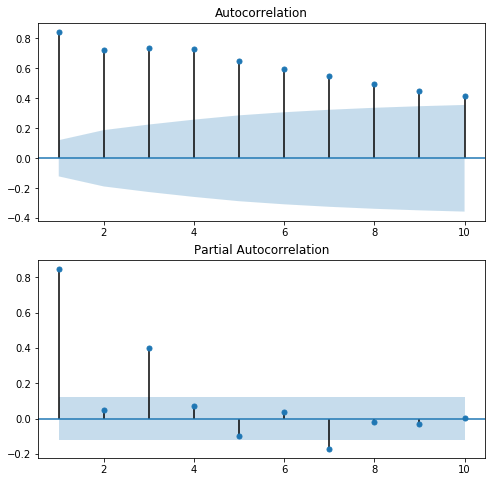

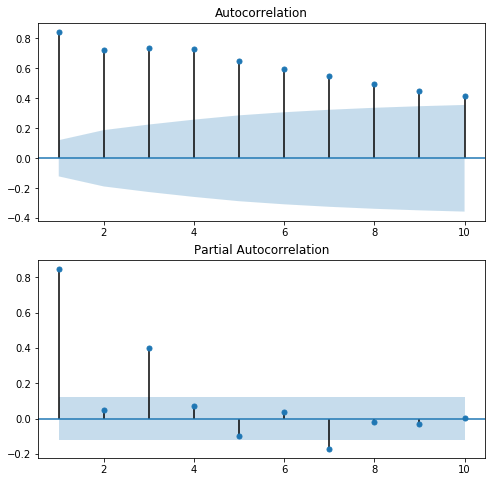

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(df_stationary_mort, lags=10, zero=False, ax=ax1)

plot_pacf(df_stationary_mort, lags=10, zero=False, ax=ax2)

Si les valeurs sont petites et se trouvent à l'intérieur de la zone ombrée en bleu, alors cela signifie qu'elles ne sont pas statistiquement significatives

<ins>Analyse résultat test 3 </ins> : L'ACF nous indique un modèle AR(4), or la PACF s'arrête au retard 1 donc nous avons un modèle AR(1)



 <ins>Modèle AR(p)</ins> :  $y_t$ = $\alpha_1$$y_{t-1}$ + $\alpha_2$$y_{t-2}$ + ... + $\alpha_p$$y_{t-p}$+  $u_t$  

 <ins>Modèle MA(q)</ins> :  $y_t$ = $\beta_1$$u_{t-1}$ + $\beta_2$$u_{t-2}$ + ... + $\beta_q$$u_{t-q}$+  $u_t$  
 
  <ins>Modèle ARMA(p,q)</ins> :  $y_t$ = $\alpha_1$$y_{t-1}$ + $\alpha_2$$y_{t-2}$ + ... + $\alpha_p$$y_{t-p}$ + $\beta_1$$u_{t-1}$ + $\beta_2$$u_{t-2}$ + ... + $\beta_q$$u_{t-q}$+  $u_t$ 
 
 
 ( $u_t$ représente le bruit blanc, cela signifie que chaque choc de la série à la date est aléatoire et n'est donc pas lié aux autres chocs de la série)

### Modèle 1 :

$ \left( \frac{mortCovid_t}{mortCovid_{t-1}} \right)$ =  $\alpha_0$ +$\alpha_1$ $\log$ $ \left( \frac{mortCovid_{t-1}}{mortCovid_{t-2}} \right)$ + $u_t$ 

In [46]:
from statsmodels.tsa.arima_model import ARMA

model= ARMA(df_stationary_mort, order=(1,0))

results= model.fit()

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result ei

In [47]:
print(results.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.015
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1416.030
Time:                            23:01:22   BIC                          -1405.313
Sample:                        03-19-2020   HQIC                         -1411.723
                             - 12-06-2020                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1372      0.146      0.937      0.349      -0.150       0.424
ar.L1.Nombre cumulé de décès     0.9956      

<ins>Interprétation modèle 1 : ARMA(1,0)</ins> : 

$\alpha_1$ = 0.99 : représente le coefficient de la variable transformée. Le coefficient est significatif au seuil de 1%




### Prévision du modèle 1 :

Méthode One-step-ahead : prédiction d'une seule valeur à l'avance

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



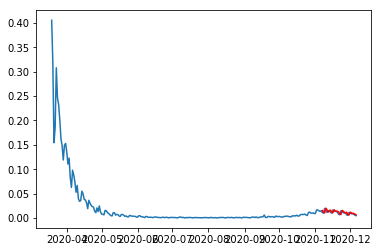

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(df_stationary_mort, order=(1,0,0), trend='c')

results=model.fit()
forecast= results.get_prediction(start=-30)

mean_forecast = forecast.predicted_mean

confidence_intervals= forecast.conf_int()

plt.plot(df_stationary_mort.index, df_stationary_mort, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')

Cette méthode utilise la valeur de la série à l’instant t-1 pour prédire la valeur à l’instant t au sein de l’échantillon.

Comme le précédent modèle, nous avons initialisé la partie AR à p=1, MA q=0 et la saisonnalité à d=0. 

Nous remarquons que la modélisation arrive à bien modéliser la série pour les 30 derniers jours de l’échantillon. Cela signifie que la valeur à l’instant t-1 est fortement corrélé et arrive bien à prédire la valeur suivante.

### Prédiction dynamique

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



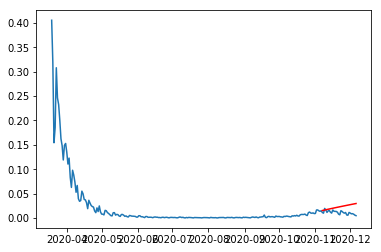

In [49]:
results=model.fit()
forecast= results.get_prediction(start=-30, dynamic=True)

mean_forecast = forecast.predicted_mean

confidence_intervals= forecast.conf_int()

plt.plot(df_stationary_mort.index, df_stationary_mort, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')

Cette méthode est similaire à la précédente, seule l’écart temporel de prédiction change. Cette fois-ci, on utilise les valeurs t-1 pour prédire les valeurs en t, t+1, t+2,…

Nous remarquons que la prédiction est moins bonne que la précédente. En effet, la prédiction indique une légère hausse du nombre de morts du Covid 19, alors qu’au sein de l’échantillon on observe une légère baisse.

### Prédiction out-Sample

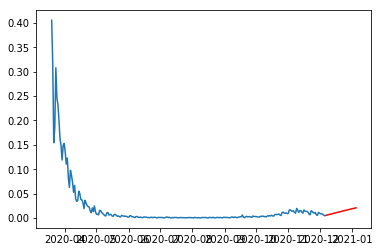

In [50]:
forecast= results.get_forecast(steps=30, dynamic=True) #Prédiction de 30 jours

mean_forecast = forecast.predicted_mean

confidence_intervals= forecast.conf_int()

plt.plot(df_stationary_mort.index, df_stationary_mort, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')

Cette fois-ci, nous utilisons toutes les données de l’échantillon pour prédire les futures valeurs (hors échantillon).

On remarque une légère hausse du nombre de décès du Covid19 pour décembre 2020. 

Cette prédiction peut sembler inattendu car depuis plusieurs jours la courbe baisse continuellement.

### Modélisation 2 : Modèle ARMAX

Il existe une extension des modèles ARMA qui consiste à ajouter une variable exogène au modèle.
C'est une combinaison entre un modèle ARMA et une régréssion linéaire.
Ici, nous allons essayer de voir si les maladies ont un effet sur le nombre de personnes mortes du Covid19.



<ins>Modèle ARMAX(1,1)</ins> :  $y_t$ = $\zeta_1$$x_t$ + $\alpha_1$$y_{t-1}$ + $\beta_1$$u_{t-1}$ + $u_t$ 

#### Stationnarisation de la variable grippe

In [51]:
#df_final2.drop(df_maladie_all.index[0], inplace=True)

results_g=adfuller(df_final3["Taux hospitalisation grippe"])
print(results_g)

(-2.2716325002586735, 0.18128031205697775, 4, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 2513.9980785020084)


In [52]:
df_stationary_g= df_final3["Taux hospitalisation grippe"].diff().dropna()

In [53]:
results_g2=adfuller(df_stationary_g)
print(results_g2)

(-6.838752522731391, 1.8139308513219172e-09, 3, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 2508.9444316766185)


In [54]:
df_stationary_g.index = pd.DatetimeIndex(df_stationary_g.index.values,
                               freq=df_stationary_mort.index.inferred_freq)

#### Stationnarisation de la variable asthme

In [55]:
results_a = adfuller(df_final3["Taux hospitalisation asthme"])
print(results_a)

(-2.000590747379833, 0.28631413711586445, 5, 258, {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}, 2288.4521947175854)


In [56]:
df_stationary_a= df_final3["Taux hospitalisation asthme"].diff().dropna()

In [57]:
results_a2=adfuller(df_stationary_a)
print(results_a2)

(-7.566135175923339, 2.922446283070642e-11, 3, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 2281.4978041989298)


In [58]:
df_stationary_a.index = pd.DatetimeIndex(df_stationary_a.index.values,
                               freq=df_stationary_mort.index.inferred_freq)

#### Stationnarisation de la variable allergie

In [59]:
results_aa = adfuller(df_final3["Taux hospitalisation allergie"])
print(results_aa)

(-2.7596761338666203, 0.06426859306818167, 12, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 1798.683245380157)


In [60]:
df_final3["Taux hospitalisation allergie"].index = pd.DatetimeIndex(df_final3["Taux hospitalisation allergie"].index.values,
                               freq=df_stationary_mort.index.inferred_freq)

In [61]:

df_final3["Taux hospitalisation allergie"].drop(df_final3["Taux hospitalisation allergie"].index[0], inplace=True)

#### Stationnarisation de la variable ORL

In [62]:
results_o = adfuller(df_final3["Taux hospitalisation ORL"])
print(results_o)

(-2.590084391267186, 0.09506398864791793, 8, 255, {'1%': -3.4562572510874396, '5%': -2.8729420379793598, '10%': -2.5728461399461744}, 1655.4110914350915)


In [63]:
df_stationary_o= df_final3["Taux hospitalisation ORL"].diff().dropna()

In [64]:
results_o=adfuller(df_stationary_o)
print(results_o)

(-5.881092831339263, 3.0771460942500507e-07, 4, 258, {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}, 1659.4422800717593)


In [65]:
df_stationary_o.index = pd.DatetimeIndex(df_stationary_o.index.values,
                               freq=df_stationary_mort.index.inferred_freq)

#### Stationnarisation de la variable Pneumopathie

In [66]:
results_p = adfuller(df_final3["Taux hospitalisation pneumopathie"])
print(results_p)

(-2.670817392424668, 0.07922569402518553, 4, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 2002.7874921130774)


In [67]:
df_final3["Taux hospitalisation pneumopathie"].index = pd.DatetimeIndex(df_final3["Taux hospitalisation pneumopathie"].index.values,
                               freq=df_stationary_mort.index.inferred_freq)

In [68]:

df_final3["Taux hospitalisation pneumopathie"].drop(df_final3["Taux hospitalisation pneumopathie"].index[0], inplace=True)

#### Stationnarisation de la variable Bronchite

In [69]:
results_b = adfuller(df_final3["Taux hospitalisation bronchite"])
print(results_b)

(-2.6318949308397523, 0.08658276171353035, 2, 261, {'1%': -3.4556556713934934, '5%': -2.872678352489859, '10%': -2.57270548832225}, 2503.7971262814144)


In [70]:
df_stationary_b= df_final3["Taux hospitalisation bronchite"].diff().dropna()

In [71]:
results_b=adfuller(df_stationary_b)
print(results_b)

(-6.632084949462903, 5.681558639092073e-09, 2, 260, {'1%': -3.4557539868570775, '5%': -2.8727214497041422, '10%': -2.572728476331361}, 2498.530436633148)


### Création du model ARMAX avec la variable grippe

$mortCovid_t$ = $\alpha$$grippe_{t}$  + $\zeta$$mortCovid_{t-1}$ +  $u_t$ 



In [72]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_stationary_g)

results_arma1= model.fit()
print(results_arma1.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.023
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1414.045
Time:                            23:01:24   BIC                          -1399.756
Sample:                        03-19-2020   HQIC                         -1408.303
                             - 12-06-2020                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1372      0.146      0.937      0.350      -0.150       0.424
Taux hospitalisation grippe  -2.998e-06   2.4

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result ei

Cette modélisation représente le nombre de décès de covid 19en fonction de sa valeur à l’instant t-1 ainsi que la variable taux d’hospitalisation grippe.

Nous remarquons que le coefficient estimé de la variable décès Covid est de 1 et est significatif au seuil de 5% TCEPA.

En revanche, le coefficient estimé de la variable taux d’hospitalisation grippe est négatif et n’est pas significatif au seuil de 5% TCEPA. Nous pouvons donc conclure que la variable taux d’hospitalisation grippe n’a à priori aucun effet sur le nombre de décès Covid19.

### Création du model ARMAX avec la variable asthme

$mortCovid_t$ = $\alpha$$asthme_{t}$  + $\zeta$$mortCovid_{t-1}$  +  $u_t$ 




In [73]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_stationary_a)

results_arma2= model.fit()
print(results_arma2.summary())

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result ei

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.015
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1414.030
Time:                            23:01:24   BIC                          -1399.741
Sample:                        03-19-2020   HQIC                         -1408.287
                             - 12-06-2020                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1375      0.147      0.936      0.350      -0.151       0.425
Taux hospitalisation asthme   -2.02e-07   3.7

Cette modélisation représente le nombre de décès de covid en fonction de sa valeur à l’instant t-1 ainsi que la variable taux d’hospitalisation Asthme.

Nous remarquons que le coefficient estimé de la variable taux d’hospitalisation asthme est négatif et n’est pas significatif au seuil de 5% TCEPA. Nous pouvons donc conclure que la variable taux d’hospitalisation asthme n’a à priori aucun effet sur le nombre de décès Covid19.

### Création du model ARMAX avec la variable allergie

$mortCovid_t$ = $\alpha$$allergie_{t}$  + $\zeta$$mortCovid_{t-1}$ + $u_t$ 




In [74]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_final3["Taux hospitalisation allergie"])

results_arma3= model.fit()
print(results_arma3.summary())

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result ei

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 712.808
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1417.615
Time:                            23:01:24   BIC                          -1403.326
Sample:                        03-19-2020   HQIC                         -1411.873
                             - 12-06-2020                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.2459      0.154      1.594      0.112      -0.057       0.548
Taux hospitalisation allergie    -0.0001  

Cette modélisation représente le nombre de décès de covid en fonction de sa valeur à l’instant t-1 ainsi que la variable taux d’hospitalisation allergie.

Nous remarquons que le coefficient estimé de la variable taux d’hospitalisation asthme est négatif et proche de 0.

La p-value= 0.057 < 10% donc la variable taux d’hospitalisation allergie est significative au seuil de 10% TCEPA.

Nous pouvons donc conclure que la variable taux d’hospitalisation allergie a un effet négative minime sur la variable nombre de décès Covid19.

### Création du model ARMAX avec la variable ORL

$mortCovid_t$ = $\alpha$$Orl_{t}$  + $\zeta$$mortCovid_{t-1}$ +  $u_t$ 





In [75]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_stationary_o)

results_arma4= model.fit()
print(results_arma4.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.177
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1414.355
Time:                            23:01:24   BIC                          -1400.066
Sample:                        03-19-2020   HQIC                         -1408.612
                             - 12-06-2020                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1359      0.145      0.937      0.349      -0.148       0.420
Taux hospitalisation ORL      7.375e-05      

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result ei

Cette modélisation représente le nombre de décès de covid en fonction de sa valeur à l’instant t-1 ainsi que la variable taux d’hospitalisation ORL.

Nous remarquons que le coefficient estimé de la variable taux d’hospitalisation ORL est positif et proche de 0.

La p-value =  0.56,  donc la variable taux d’hospitalisation ORL n’est pas significative au seuil de 10% TCEPA.

Nous pouvons conclure que la variable taux d’hospitalisation ORL n’a aucun impact sur la variable nombre de décès Covid19.

### Création du model ARMAX avec la variable Pneumopathie

$mortCovid_t$ = $\alpha$$Pneumopathie_{t}$  + $\zeta$$mortCovid_{t-1}$ +  $u_t$ 

In [76]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_final3["Taux hospitalisation pneumopathie"])

results_arma5= model.fit()
print(results_arma5.summary())

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result ei

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 669.293
Method:                           css-mle   S.D. of innovations              0.019
Date:                    Tue, 15 Dec 2020   AIC                          -1330.586
Time:                            23:01:24   BIC                          -1316.297
Sample:                        03-19-2020   HQIC                         -1324.844
                             - 12-06-2020                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.2911      0.120      2.424      0.016       0.056       0.526
Taux hospitalisation pneumopat

Cette modélisation représente le nombre de décès de covid en fonction de sa valeur à l’instant t-1 ainsi que la variable taux d’hospitalisation pneumopathie.

Nous remarquons que le coefficient estimé de la variable taux d’hospitalisation pneumopathie est positif et proche de 0.

La p-value =  0.041,  donc la variable taux d’hospitalisation pneumopathie est significative au seuil de 5% TCEPA.

Nous pouvons donc conclure que la variable a un effet positif mais minime sur la variable nombre de décès Covid19.

### Création du model ARMAX avec la variable Bronchite

$mortCovid_t$ = $\alpha$$Bronchite_{t}$  + $\zeta$$mortCovid_{t-1}$ +  $u_t$ 

In [77]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_stationary_b)

results_arma6= model.fit()
print(results_arma6.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning:

Using a non-tuple sequence for multidimensiona

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.016
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1414.032
Time:                            23:01:25   BIC                          -1399.743
Sample:                        03-19-2020   HQIC                         -1408.290
                             - 12-06-2020                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.1372      0.146      0.937      0.349      -0.150       0.424
Taux hospitalisation bronchite  1.229e-

Cette modélisation représente le nombre de décès de covid en fonction de sa valeur à l’instant t-1 ainsi que la variable taux d’hospitalisation bronchite.

Nous remarquons que le coefficient estimé de la variable taux d’hospitalisation bronchite est positif et proche de 0.

La p-value = 0.05,  donc la variable taux d’hospitalisation pneumopathie est significative au seuil de 5% TCEPA.

Nous pouvons donc conclure que la variable a un effet positif mais minime sur la variable nombre de décès Covid19.

A l’aide des modèles ARMA, nous avons montré qu’il n’existe pas de liens statistiques entre la variable à expliquer « décès Covid19 » et les maladies, ce qui confirme nos observations aux parties précédentes.

Seules les variables explicatives pneumopathie, bronchite et allergie sont significatives mais n’ont quasiment aucun effet sur la variable à expliquer.

### Analyse temporelle de la variable nombre de personnes hostpitalisés (sans transformation de la série)

Au lieu de prendre la différence ou tout autre transformation de la série temporelle, nous allons prendre la somme cumulée (ou intégrale).
Cette transformation nous permettra de réaliser des prédictions des valeurs "brute" de la série. Les modèles ARIMA représentes une extensions des modèles ARMA avec en plus un paramètre de différentiation auto-intégré.  

ARIMA : Autoregressive integrated Moving Average

Cette méthode ne peut pas s'appliquer à la variable "mort covid 19" car nous avons appliquer une transformation logarithmique et non une transformation différentielle



### Aperçu du nombre de lag nécessaire à la stationnarisation de la variable hostpitalisation C19

In [78]:
results=adfuller(df_final3["Nombre de personnes hospitalisées"])
print(results)

(-1.6757485575228641, 0.4436488621451615, 16, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 3206.946889674941)


In [79]:
df_stationary_h= df_final3["Nombre de personnes hospitalisées"].diff().dropna()

In [80]:
results2=adfuller(df_stationary_h)
print(results2)

(-3.945241363965287, 0.0017260063542060616, 15, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 3188.8969560656933)


La variable "hospit C19" (nombre de personnes hostpitalisés du Covid 19) nécessite de différencié 1 seule fois 

### Recherche du meilleur paramètre

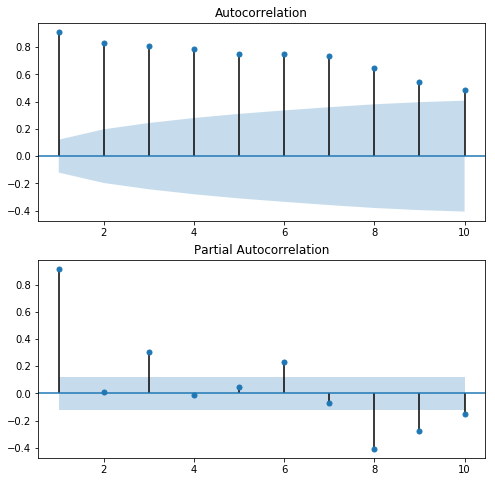

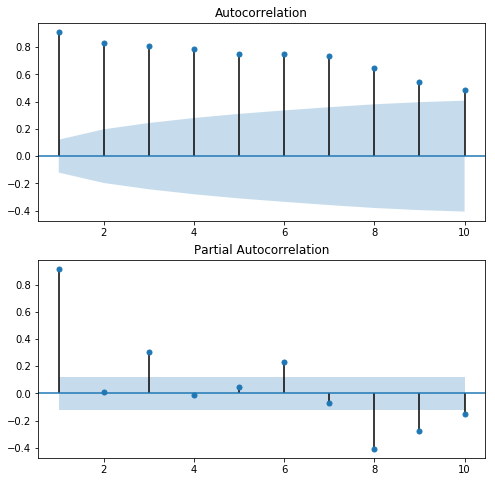

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(df_stationary_h, lags=10, zero=False, ax=ax1)

plot_pacf(df_stationary_h, lags=10, zero=False, ax=ax2)

In [82]:
df_final3["Nombre de personnes hospitalisées"].index = pd.DatetimeIndex(df_final3["Nombre de personnes hospitalisées"].index.values,
                               freq=df_stationary_mort.index.inferred_freq)

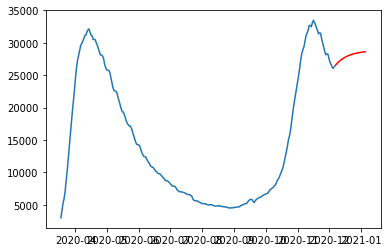

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_final3["Nombre de personnes hospitalisées"], order=(1,1,0))

model_results=model.fit()

mean_forecast= model_results.get_forecast(steps=30).predicted_mean


plt.plot(df_final3["Nombre de personnes hospitalisées"].index, df_final3["Nombre de personnes hospitalisées"], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')



Nous remarquons que la prédiction de la variable « nombre de personnes hospitalisées » n’est pas représentative de l’allure générale de la série dans l’échantillon. En effet, nous devrions avoir une continuité de la décroissance de la série et non une soudaine augmentation du nombre de personnes hospitalisées.

Les causes de cette mauvaise prédiction peuvent provenir soit des caractéristiques de la série elle-même, c’est-à-dire, aucune saisonnalité, aucune tendance, cycle inattendu, soit du choix des paramètres.

**Conclusion** 

A travers notre démarche scientifique, nous avons démontré qu’il n’existait pas de liens statistiques entre le nombre de décès de la Covid 19 et les maladies classiques telles que la grippe, l’allergie, l’asthme ou encore la pneumopathie.

 

Les premiers signaux indiquant la non-corrélation sont d’abord apparus dans les statistiques descriptives. En effet, les heatmaps et les graphiques ont montré qu’à travers le temps, la variable décès Covid19 était indépendante des autres variables maladies. 


En ce qui concerne les facteurs socio-économiques, les statistiques descriptives et les régressions linéaires ont montré une corrélation positive entre le nombre de décès de la Covid 19 et des variables telles que la densité de la population, la taille moyenne des ménages, la surrocupation des résidences principales, l'utilisation des transport en commun ou encore le nombre de commerces.


La modélisation des séries temporelles est venue confirmer notre intuition. Chaque modèle incluant une variable exogène maladie a montré que cette dernière n’était pas statistiquement significative.


Les résultats de la prédiction sont malheureusement peu réalistes de la réalité. Cela est due à la complexité de la série étudiée « Mort cumulés Covid 19 ». En effet, il est assez compliqué de stationnariser une série comportant 2 cycles aléatoires au sein de l’échantillon. Cette complication induit en erreur le choix des paramètres et donc de la prédiction.

Une amélioration pourrait être faite en analysant la variable sur une plus longue période afin de déterminer si ces cycles sont redondants ou pas. Dans ce cas-là, il serait possible d’inclure un paramètre « cycle » dans le modèle.